Training with ExplicitEuclidean...
Training with Adam...


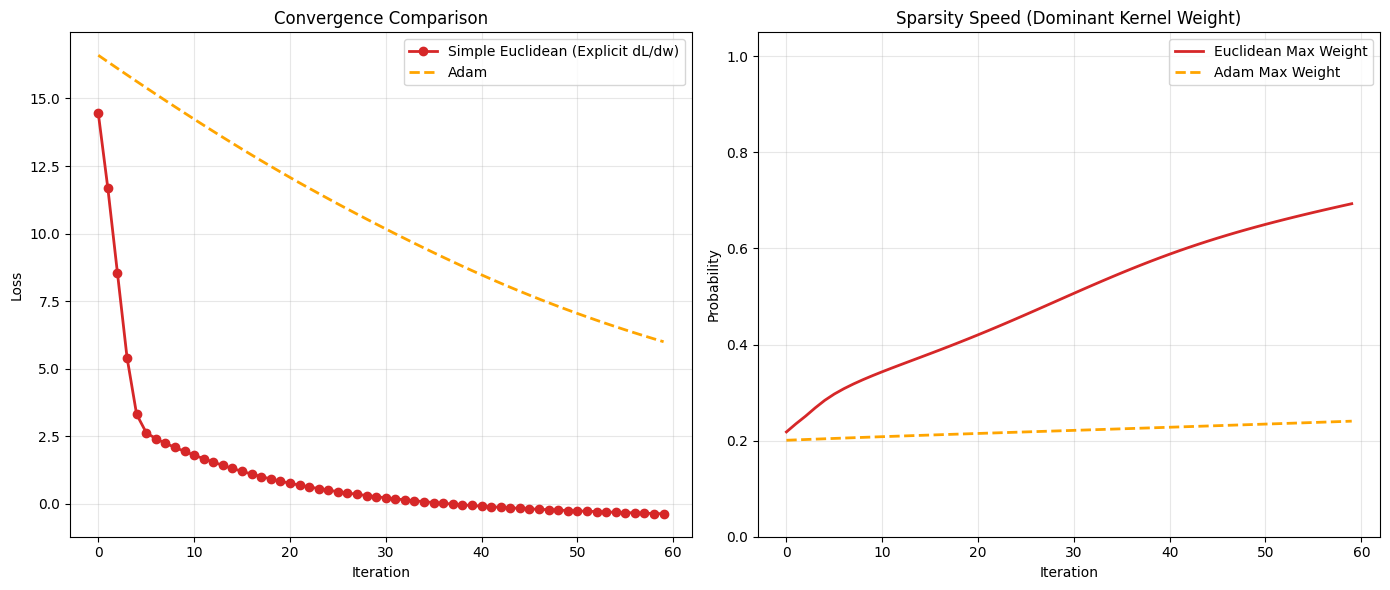


Final Weights Distribution:
Simple Euclidean: [0.    0.693 0.178 0.061 0.068]
Adam            : [0.077 0.241 0.232 0.225 0.225]


In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

DTYPE = torch.float64
torch.set_default_dtype(DTYPE)

# --- 1. Optimizer: Simple Euclidean Gradient for Simplex ---
class SimpleEuclideanSimplex(optim.Optimizer):
    """
    期待値パラメータ w のユークリッド勾配を明示的に復元して利用するオプティマイザ。
    
    理論背景:
      通常、PyTorchのbackward()は自然パラメータ theta に関する勾配 (dL/dtheta) を計算します。
      しかし、Natural Gradientは理論上、期待値パラメータ空間での最急降下方向 (dL/dw) と一致します。
      
      ここで、dL/dw = (dL/dtheta) / w  (要素ごとの除算)
      という関係を利用し、逆行列計算なしで高速に自然勾配方向を算出します。
    """
    def __init__(self, params, lr=0.01):
        defaults = dict(lr=lr)
        super(SimpleEuclideanSimplex, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue

                # 1. 期待値パラメータ w (重み) の計算
                w = torch.softmax(p, dim=0)
                
                # 2. 自然パラメータの勾配 (dL/dtheta) を取得
                d_theta = p.grad
                
                # 3. 期待値パラメータのユークリッド勾配 (dL/dw) を明示的に復元
                # 数式: dL/dw_i = dL/dtheta_i / w_i
                # (0除算を防ぐため微小項 eps を加算)
                eps = 1e-12
                d_w_explicit = d_theta / (w + eps)
                
                # 4. ドリフト防止のための中心化 (Mean Subtraction)
                # Softmaxは定数シフトに対して不変なので、勾配の平均を引いても挙動は同じだが、
                # thetaの値が発散するのを防ぐために重要。
                d_w_explicit -= d_w_explicit.mean()

                # 5. 更新: theta <- theta - lr * dL/dw
                # これにより、実質的に自然勾配法と同じ方向へ最速で進む
                p.sub_(group['lr'] * d_w_explicit)
                
        return loss

# --- 2. Model (MKLGP) ---
class MKLGP(nn.Module):
    def __init__(self, n_kernels, initial_length_scales):
        super(MKLGP, self).__init__()
        self.theta = nn.Parameter(torch.zeros(n_kernels, dtype=DTYPE))
        self.log_length_scales = nn.Parameter(torch.log(torch.tensor(initial_length_scales, dtype=DTYPE)))
        self.log_noise_var = nn.Parameter(torch.log(torch.tensor(0.1**2, dtype=DTYPE)))

    @property
    def weights(self):
        return torch.softmax(self.theta, dim=0)
    
    @property
    def length_scales(self):
        return torch.exp(self.log_length_scales)
    
    @property
    def noise_variance(self):
        return torch.exp(self.log_noise_var)

    def compute_kernel(self, X1, X2=None):
        if X2 is None: X2 = X1
        w = self.weights
        ls = self.length_scales
        dists_sq = torch.cdist(X1, X2, p=2)**2
        K_total = torch.zeros(X1.size(0), X2.size(0), dtype=DTYPE, device=X1.device)
        for i in range(len(w)):
            K_total += w[i] * torch.exp(-0.5 * dists_sq / (ls[i]**2))
        return K_total

    def negative_log_marginal_likelihood(self, X, y):
        K = self.compute_kernel(X)
        K_noise = K + self.noise_variance * torch.eye(X.size(0), device=X.device)
        try:
            mvn = torch.distributions.MultivariateNormal(torch.zeros_like(y), covariance_matrix=K_noise)
        except ValueError:
            K_noise += 1e-5 * torch.eye(X.size(0), device=X.device)
            mvn = torch.distributions.MultivariateNormal(torch.zeros_like(y), covariance_matrix=K_noise)
        return -mvn.log_prob(y)

# --- 3. Training & Comparison ---
def train_model(optimizer_type, X_train, y_train, n_iter=60):
    torch.manual_seed(42)
    np.random.seed(42)
    
    initial_ls = [0.1, 0.5, 2.0, 5.0, 10.0]
    model = MKLGP(n_kernels=len(initial_ls), initial_length_scales=initial_ls)
    
    # Optimizer Selection
    lr_weights = 0.01 # 比較のため高めの学習率
    
    if optimizer_type == 'ExplicitEuclidean':
        # 今回実装した「明示的ユークリッド勾配」版
        optim_weights = SimpleEuclideanSimplex([model.theta], lr=lr_weights)
    elif optimizer_type == 'Adam':
        optim_weights = optim.Adam([model.theta], lr=lr_weights)
    
    optim_hyper = optim.Adam([model.log_length_scales, model.log_noise_var], lr=0.01)
    
    loss_history = []
    weights_history = []
    
    print(f"Training with {optimizer_type}...")
    for i in range(n_iter):
        optim_weights.zero_grad()
        loss = model.negative_log_marginal_likelihood(X_train, y_train)
        loss.backward()
        optim_weights.step()
        
        optim_hyper.zero_grad()
        loss = model.negative_log_marginal_likelihood(X_train, y_train)
        loss.backward()
        optim_hyper.step()
        
        with torch.no_grad():
            loss_history.append(loss.item())
            weights_history.append(model.weights.clone().detach().cpu().numpy())
            
    return loss_history, np.array(weights_history)

# --- 4. Main Execution ---
def run_experiment():
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Data Generation
    X_train = torch.tensor(np.random.uniform(0, 10, 40).reshape(-1, 1), dtype=DTYPE)
    y_train_np = (np.sin(X_train.numpy()) + 0.5 * np.sin(3 * X_train.numpy())).flatten() + np.random.normal(0, 0.1, 40)
    y_train = torch.tensor(y_train_np, dtype=DTYPE)

    # Run
    loss_euc, weights_euc = train_model('ExplicitEuclidean', X_train, y_train)
    loss_adam, weights_adam = train_model('Adam', X_train, y_train)

    # Visualization
    plt.figure(figsize=(14, 6))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(loss_euc, label='Simple Euclidean (Explicit dL/dw)', linewidth=2, marker='o', color='tab:red')
    plt.plot(loss_adam, label='Adam', linewidth=2, linestyle='--', color='orange')
    plt.title('Convergence Comparison')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    # plt.yscale('log') # 差を見やすくするため対数表示推奨
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Sparsity
    plt.subplot(1, 2, 2)
    plt.plot(np.max(weights_euc, axis=1), label='Euclidean Max Weight', color='tab:red', linewidth=2)
    plt.plot(np.max(weights_adam, axis=1), label='Adam Max Weight', color='orange', linestyle='--', linewidth=2)
    plt.title('Sparsity Speed (Dominant Kernel Weight)')
    plt.xlabel('Iteration')
    plt.ylabel('Probability')
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    print("\nFinal Weights Distribution:")
    print("Simple Euclidean:", np.round(weights_euc[-1], 3))
    print("Adam            :", np.round(weights_adam[-1], 3))

if __name__ == "__main__":
    run_experiment()

Start Training with NGD...
Start Training with Adam...


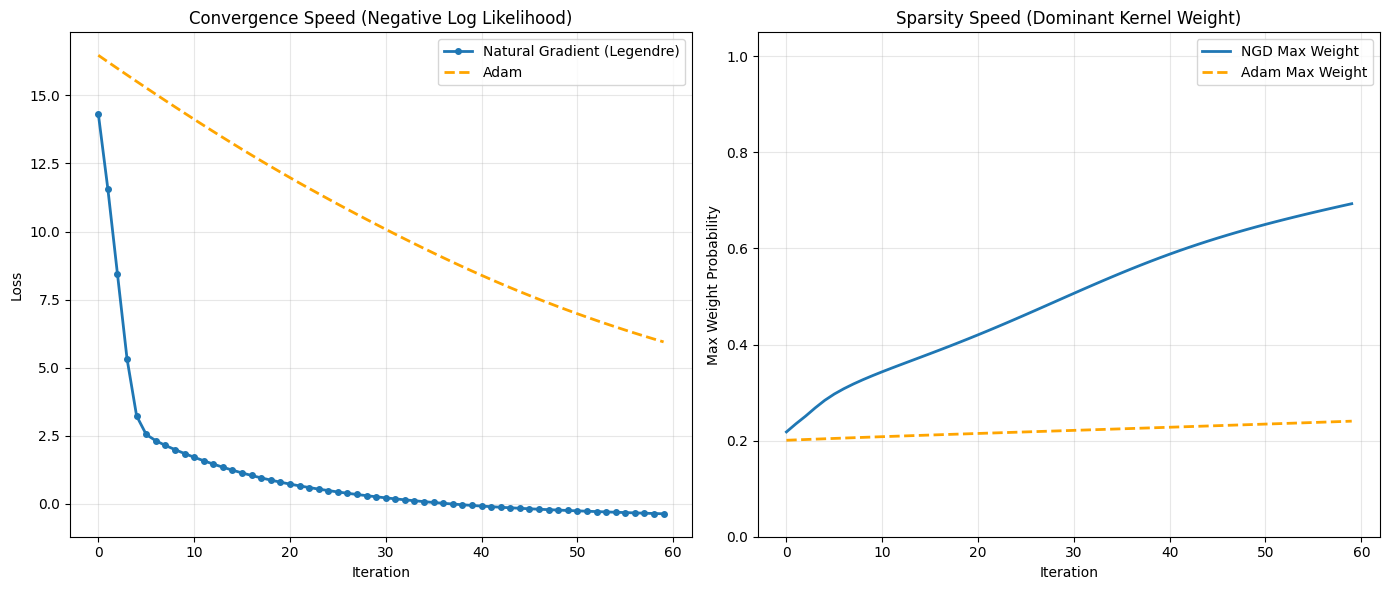


Final Weights Distribution:
Kernel Scales: [0.1, 0.5, 2.0, 5.0, 10.0]
NGD Weights:   [0.    0.693 0.178 0.061 0.068]
Adam Weights:  [0.077 0.241 0.232 0.225 0.225]


In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# --- 0. Configuration ---
# ガウス過程は数値計算が繊細なため、倍精度(float64)を使用します
DTYPE = torch.float64
torch.set_default_dtype(DTYPE)

# --- 1. Optimizer Class: Natural Gradient for Simplex ---
class NaturalGradientSimplex(optim.Optimizer):
    """
    Legendre Decomposition (Sugiyama et al.) の理論に基づく自然勾配法オプティマイザ。
    確率単体 (Simplex) 上のパラメータ最適化に特化しています。
    """
    def __init__(self, params, lr=0.1, damping=1e-5):
        defaults = dict(lr=lr, damping=damping)
        super(NaturalGradientSimplex, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue
                
                # 自然パラメータ theta (p) から 期待値パラメータ w (重み) を計算
                w = torch.softmax(p, dim=0)
                
                # [cite_start]フィッシャー情報行列 G の計算 [cite: 171]
                # G = diag(w) - w * w.T
                G = torch.diag(w) - torch.outer(w, w)
                
                # 数値安定性のための Damping
                G.diagonal().add_(group['damping'])
                
                # 勾配 (dL/dtheta)
                grad_theta = p.grad
                
                # 自然勾配の計算: G^-1 * grad
                # SoftmaxのGはランク落ちするため、擬似逆行列(pinv)を使用
                nat_grad = torch.linalg.pinv(G) @ grad_theta
                
                # パラメータ更新
                p.sub_(group['lr'] * nat_grad)
                
        return loss

# --- 2. Model: Multiple Kernel Learning Gaussian Process ---
class MKLGP(nn.Module):
    def __init__(self, n_kernels, initial_length_scales):
        super(MKLGP, self).__init__()
        # 自然パラメータ theta (最適化対象)
        self.theta = nn.Parameter(torch.zeros(n_kernels, dtype=DTYPE))
        
        # カーネルの長さスケールとノイズ分散 (ハイパーパラメータ)
        self.log_length_scales = nn.Parameter(torch.log(torch.tensor(initial_length_scales, dtype=DTYPE)))
        self.log_noise_var = nn.Parameter(torch.log(torch.tensor(0.1**2, dtype=DTYPE)))

    @property
    def weights(self):
        return torch.softmax(self.theta, dim=0)
    
    @property
    def length_scales(self):
        return torch.exp(self.log_length_scales)
    
    @property
    def noise_variance(self):
        return torch.exp(self.log_noise_var)

    def compute_kernel(self, X1, X2=None):
        if X2 is None: X2 = X1
        w = self.weights
        ls = self.length_scales
        
        # RBFカーネルの計算
        dists_sq = torch.cdist(X1, X2, p=2)**2
        K_total = torch.zeros(X1.size(0), X2.size(0), dtype=DTYPE, device=X1.device)
        
        # 重み付き和: K_total = Σ w_i * K_i
        for i in range(len(w)):
            K_total += w[i] * torch.exp(-0.5 * dists_sq / (ls[i]**2))
            
        return K_total

    def negative_log_marginal_likelihood(self, X, y):
        # 負の対数周辺尤度 (最小化対象)
        K = self.compute_kernel(X)
        K_noise = K + self.noise_variance * torch.eye(X.size(0), device=X.device)
        
        try:
            mvn = torch.distributions.MultivariateNormal(torch.zeros_like(y), covariance_matrix=K_noise)
        except ValueError:
            # 数値的安定性のためのフォールバック
            K_noise += 1e-5 * torch.eye(X.size(0), device=X.device)
            mvn = torch.distributions.MultivariateNormal(torch.zeros_like(y), covariance_matrix=K_noise)
            
        return -mvn.log_prob(y)

# --- 3. Training Function ---
def train_model(optimizer_type, X_train, y_train, n_iter=60):
    # 公平な比較のためにシードをリセット
    torch.manual_seed(42)
    np.random.seed(42)
    
    # 異なる長さスケールを持つ5つのカーネルを用意
    initial_ls = [0.1, 0.5, 2.0, 5.0, 10.0]
    model = MKLGP(n_kernels=len(initial_ls), initial_length_scales=initial_ls)
    
    # オプティマイザの設定
    lr_weights = 0.01 # 学習率 (比較のため共通)
    
    if optimizer_type == 'NGD':
        # 重み w の学習に自然勾配法を使用
        optim_weights = NaturalGradientSimplex([model.theta], lr=lr_weights)
    elif optimizer_type == 'Adam':
        # 重み w の学習にAdamを使用
        optim_weights = optim.Adam([model.theta], lr=lr_weights)
    
    # ハイパーパラメータ (長さスケール等) は常にAdamで学習
    optim_hyper = optim.Adam([model.log_length_scales, model.log_noise_var], lr=0.01)
    
    loss_history = []
    weights_history = []
    
    print(f"Start Training with {optimizer_type}...")
    
    # 学習ループ
    for i in range(n_iter):
        # 1. カーネル重み (theta) の更新
        optim_weights.zero_grad()
        loss = model.negative_log_marginal_likelihood(X_train, y_train)
        loss.backward()
        optim_weights.step()
        
        # 2. ハイパーパラメータの更新
        optim_hyper.zero_grad()
        loss = model.negative_log_marginal_likelihood(X_train, y_train)
        loss.backward()
        optim_hyper.step()
        
        # 記録
        with torch.no_grad():
            loss_val = model.negative_log_marginal_likelihood(X_train, y_train).item()
            loss_history.append(loss_val)
            weights_history.append(model.weights.clone().detach().cpu().numpy())
            
    return loss_history, np.array(weights_history)

# --- 4. Main Experiment ---
def run_experiment():
    # データ生成
    torch.manual_seed(42)
    np.random.seed(42)
    
    # 入力: 0~10の範囲
    X_train_np = np.random.uniform(0, 10, 40).reshape(-1, 1)
    # 出力: 周期性の異なるサイン波の合成 + ノイズ
    # (長さスケール 2.0 と 0.5 あたりが重要になるはず)
    y_train_np = (np.sin(X_train_np) + 0.5 * np.sin(3 * X_train_np)).flatten() + np.random.normal(0, 0.1, 40)
    
    X_train = torch.tensor(X_train_np, dtype=DTYPE)
    y_train = torch.tensor(y_train_np, dtype=DTYPE)

    # 比較実験の実行
    loss_ngd, weights_ngd = train_model('NGD', X_train, y_train)
    loss_adam, weights_adam = train_model('Adam', X_train, y_train)

    # --- 可視化 ---
    plt.figure(figsize=(14, 6))

    # Plot 1: Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(loss_ngd, label='Natural Gradient (Legendre)', linewidth=2, marker='o', markersize=4)
    plt.plot(loss_adam, label='Adam', linewidth=2, linestyle='--', color='orange')
    plt.title('Convergence Speed (Negative Log Likelihood)')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 2: Max Weight Evolution (Sparsity Check)
    # 「最も重要なカーネル」の重みがどれだけ速く 1 に近づくか
    plt.subplot(1, 2, 2)
    plt.plot(np.max(weights_ngd, axis=1), label='NGD Max Weight', color='tab:blue', linewidth=2)
    plt.plot(np.max(weights_adam, axis=1), label='Adam Max Weight', color='orange', linestyle='--', linewidth=2)
    plt.title('Sparsity Speed (Dominant Kernel Weight)')
    plt.xlabel('Iteration')
    plt.ylabel('Max Weight Probability')
    plt.ylim(0, 1.05)
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    # 最終的な重みの表示
    print("\nFinal Weights Distribution:")
    print("Kernel Scales:", [0.1, 0.5, 2.0, 5.0, 10.0])
    print("NGD Weights:  ", np.round(weights_ngd[-1], 3))
    print("Adam Weights: ", np.round(weights_adam[-1], 3))

if __name__ == "__main__":
    run_experiment()

Comparison Start: Learning Rate=5.0, Damping(Explicit only)=0.1


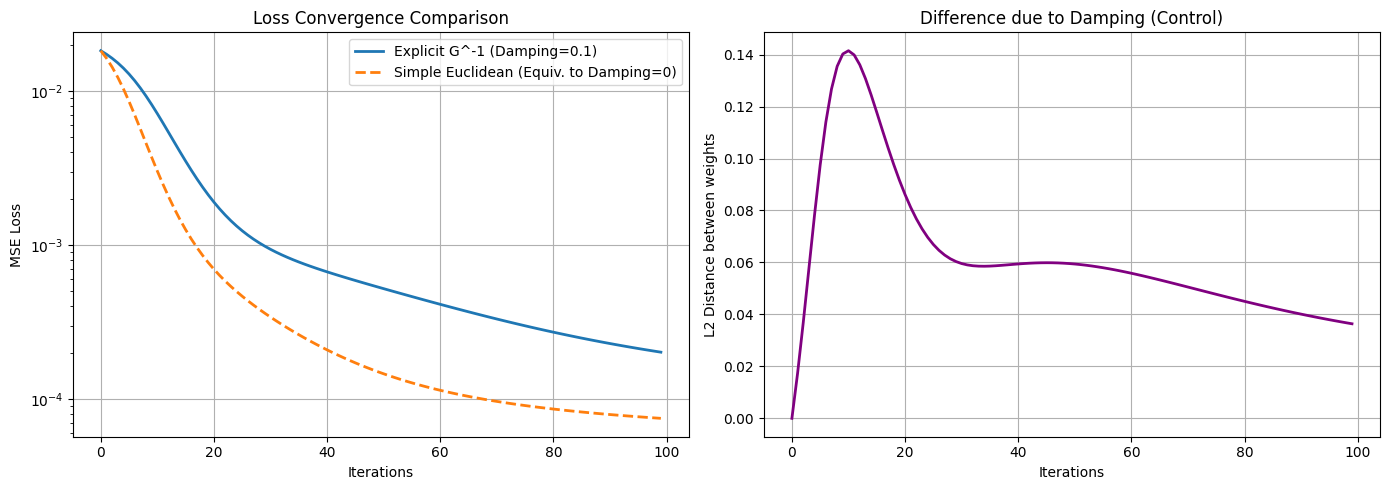

In [47]:
import numpy as np
import matplotlib.pyplot as plt

class LegendreOptimizerComparison:
    """
    2つのアプローチを比較するためのオプティマイザクラス
    1. Explicit: 逆行列 G^-1 を明示的に計算 (Dampingあり)
    2. Simple: 期待値パラメータのユークリッド勾配を利用 (Dampingなしの自然勾配と等価)
    """
    def __init__(self, n_kernels, learning_rate=0.1, damping=0.0):
        self.n_kernels = n_kernels
        self.lr = learning_rate
        self.damping = damping
        
        # 比較のため、全く同じ初期値からスタート
        self.theta_explicit = np.zeros(n_kernels)
        self.theta_simple = np.zeros(n_kernels)

    def softmax(self, theta):
        """自然パラメータ -> 期待値パラメータ(重み)"""
        exp_theta = np.exp(theta - np.max(theta)) # オーバーフロー対策
        return exp_theta / np.sum(exp_theta)

    def get_weights(self, mode='explicit'):
        if mode == 'explicit':
            return self.softmax(self.theta_explicit)
        else:
            return self.softmax(self.theta_simple)

    def step_explicit(self, grad_w):
        """
        アプローチA: 逆行列を明示的に計算する
        メリット: Damping項を入れることで、学習の「過激さ」を抑制・調整できる
        """
        w = self.get_weights('explicit')
        
        # 1. Fisher Information Matrix G
        G = np.diag(w) - np.outer(w, w)
        
        # 2. Damping (ここが調整ポイント！)
        # 対角成分に小さな値を足すことで、特異性を回避しつつステップを抑制する
        G_damped = G + self.damping * np.eye(self.n_kernels)
        
        # 3. 勾配の変換 dL/dtheta = G @ dL/dw
        grad_theta = G @ grad_w
        
        # 4. 自然勾配: inv(G_damped) @ grad_theta
        # damping > 0 なので安定して逆行列が求まる
        nat_grad = np.linalg.inv(G_damped) @ grad_theta
            
        self.theta_explicit -= self.lr * nat_grad

    def step_simple(self, grad_w):
        """
        アプローチB: 期待値パラメータのユークリッド勾配をそのまま使う
        メリット: 計算が非常に高速
        デメリット: Dampingのような微調整ができない（常に全力で自然勾配方向に進む）
        """
        # 理論上、Simplex上では G^-1 @ G @ grad_w = grad_w となるため、
        # そのまま引くだけで自然勾配になる。
        
        # ただし、thetaのドリフトを防ぐために勾配の中心化（平均引き）だけ行う
        grad_w_centered = grad_w - np.mean(grad_w)
        
        self.theta_simple -= self.lr * grad_w_centered

# --- 実行と可視化 ---

def run_comparison():
    np.random.seed(42)
    
    # 問題設定: スパースな重みを持つ回帰問題
    n_kernels = 10
    true_weights = np.random.dirichlet(np.ones(n_kernels), size=1)[0]
    true_weights = true_weights ** 3 # よりスパースにする
    true_weights /= true_weights.sum()
    
    n_samples = 200
    X = np.random.rand(n_samples, n_kernels)
    noise = np.random.normal(0, 0.01, n_samples)
    y = X @ true_weights + noise
    
    # ハイパーパラメータ
    lr = 5.0  # 高めの学習率
    damping_val = 0.1 # 明示的な「調整」の効果を見るためのDamping
    
    optimizer = LegendreOptimizerComparison(n_kernels, learning_rate=lr, damping=damping_val)
    
    losses_explicit = []
    losses_simple = []
    diff_w_history = [] 
    
    n_steps = 100
    
    print(f"Comparison Start: Learning Rate={lr}, Damping(Explicit only)={damping_val}")
    
    for t in range(n_steps):
        # --- 1. Explicit Update (with Damping) ---
        w_exp = optimizer.get_weights('explicit')
        y_pred_exp = X @ w_exp
        loss_exp = 0.5 * np.mean((y - y_pred_exp)**2)
        losses_explicit.append(loss_exp)
        
        grad_w_exp = (X.T @ (y_pred_exp - y)) / n_samples
        optimizer.step_explicit(grad_w_exp)
        
        # --- 2. Simple Update (No Damping) ---
        w_simp = optimizer.get_weights('simple')
        y_pred_simp = X @ w_simp
        loss_simp = 0.5 * np.mean((y - y_pred_simp)**2)
        losses_simple.append(loss_simp)
        
        grad_w_simp = (X.T @ (y_pred_simp - y)) / n_samples
        optimizer.step_simple(grad_w_simp)
        
        # 重みの乖離を記録
        diff = np.linalg.norm(w_exp - w_simp)
        diff_w_history.append(diff)

    # 結果のプロット
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss Curve
    ax1.plot(losses_explicit, label=f'Explicit G^-1 (Damping={damping_val})', linewidth=2)
    ax1.plot(losses_simple, label='Simple Euclidean (Equiv. to Damping=0)', linewidth=2, linestyle='--')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('MSE Loss')
    ax1.set_title('Loss Convergence Comparison')
    ax1.set_yscale('log')
    ax1.legend()
    ax1.grid(True)
    
    # Weight Difference
    ax2.plot(diff_w_history, color='purple', linewidth=2)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('L2 Distance between weights')
    ax2.set_title(f'Difference due to Damping (Control)')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_comparison()

True Weights:    [0.9  0.05 0.05]
NGD Weights:     [0.9015 0.0462 0.0523]
Std GD Weights:  [0.4589 0.2722 0.2688]


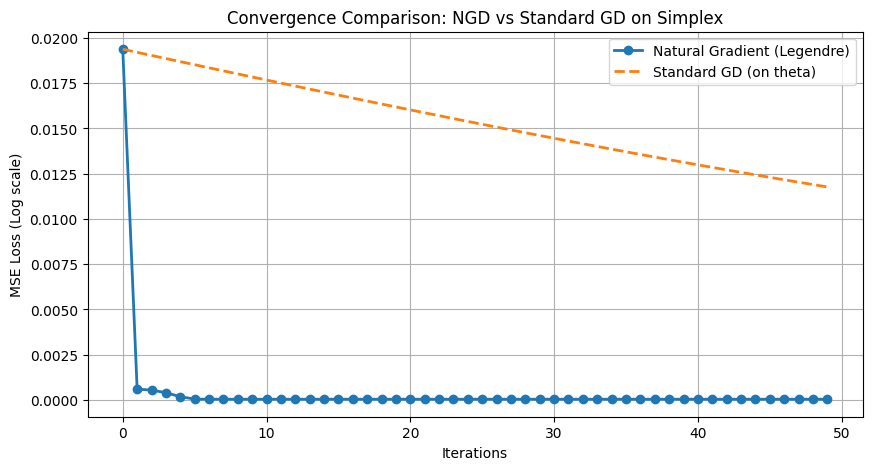

In [14]:
import numpy as np
import matplotlib.pyplot as plt

class LegendreSimplexOptimizer:
    """
    Legendre Decomposition for Tensors (Sugiyama et al.) の枠組みを用いた
    確率単体（Simplex）上の自然勾配法オプティマイザ。
    """
    def __init__(self, n_kernels, learning_rate=0.1, damping=1e-5):
        self.n_kernels = n_kernels
        self.lr = learning_rate
        self.damping = damping # 数値安定性のための微小項
        
        # 自然パラメータ theta (論文中の \theta)
        # 初期値は0（等確率）
        self.theta = np.zeros(n_kernels)

    def softmax(self, theta):
        """自然パラメータ theta から 期待値パラメータ eta (重み w) への変換"""
        exp_theta = np.exp(theta - np.max(theta)) # オーバーフロー対策
        return exp_theta / np.sum(exp_theta)

    def get_weights(self):
        """現在のカーネル重み w (eta) を取得"""
        return self.softmax(self.theta)

    def compute_fisher_matrix(self, w):
        """
        論文の Eq (5) に基づくフィッシャー情報行列 G の計算。
        1階のテンソル（ベクトル）の場合、これは多項分布のフィッシャー情報行列と一致します。
        
        g_{uv} = Σ p_w ζ(u,w) ζ(v,w) - η_u η_v
        ベクトルかつ全結合(Softmax)の場合: G = diag(w) - w @ w.T
        """
        # G = diag(w) - w * w^T
        G = np.diag(w) - np.outer(w, w)
        return G

    def step(self, grad_w):
        """
        パラメータの更新 (Algorithm 2 の Natural Gradient update)
        
        Args:
            grad_w: 損失関数 L の 重み w に関する勾配 (dL/dw)
        """
        w = self.get_weights()
        
        # 1. フィッシャー情報行列 G の計算 
        G = self.compute_fisher_matrix(w)
        
        # 2. 自然パラメータ theta に関する勾配の計算 (Chain Rule)
        # dL/dtheta = (dw/dtheta) * (dL/dw)
        # 実は Softmax のヤコビアン (dw/dtheta) は G そのものです。
        grad_theta = G @ grad_w
        
        # 3. 自然勾配 (Natural Gradient) の計算
        # update_direction = G^{-1} * grad_theta
        # SoftmaxのGはランク落ち(特異行列)するため、擬似逆行列(pinv)またはdampingを使用
        
        # 数値安定化のため damping を対角成分に加算
        G_damped = G + self.damping * np.eye(self.n_kernels)
        
        # 逆行列を計算 [cite: 1189]
        # inv_G = np.linalg.inv(G_damped) 
        # nat_grad = inv_G @ grad_theta
        
        # より堅牢な pinv を使用（論文の基底 B の議論に準拠し、冗長な次元を無視する）
        nat_grad = np.linalg.pinv(G) @ grad_theta

        # 4. パラメータ更新
        self.theta -= self.lr * nat_grad

# --- 実験用: ダミーのカーネル回帰問題 ---

def run_experiment():
    np.random.seed(43)
    
    # 真の重み (スパースな設定: カーネル1だけが重要)
    true_weights = np.array([0.9, 0.05, 0.05])
    n_kernels = len(true_weights)
    
    # データ生成 (y = w1*x1 + w2*x2 + w3*x3 + noise)
    # ここでは x_i 自体が「各カーネルによる予測値」とみなします
    n_samples = 100
    X_kernels = np.random.rand(n_samples, n_kernels) # 各カーネルの出力
    y = X_kernels @ true_weights + np.random.normal(0, 0.01, n_samples)
    
    # モデル設定
    optimizer_ngd = LegendreSimplexOptimizer(n_kernels, learning_rate=100)
    
    # 比較用: 標準的な勾配降下法 (Standard GD on theta)
    theta_gd = np.zeros(n_kernels)
    lr_gd = 0.5
    
    losses_ngd = []
    losses_gd = []
    
    # 学習ループ
    n_steps = 50
    for t in range(n_steps):
        # --- 1. Natural Gradient (Legendre Decomposition approach) ---
        w_ngd = optimizer_ngd.get_weights()
        y_pred_ngd = X_kernels @ w_ngd
        loss_ngd = 0.5 * np.mean((y - y_pred_ngd)**2)
        losses_ngd.append(loss_ngd)
        
        # 勾配計算 dL/dw = (y_pred - y) * X
        grad_w_ngd = (X_kernels.T @ (y_pred_ngd - y)) / n_samples
        
        # 更新
        optimizer_ngd.step(grad_w_ngd)
        
        # --- 2. Standard Gradient Descent ---
        # Softmax
        exp_theta = np.exp(theta_gd - np.max(theta_gd))
        w_gd = exp_theta / np.sum(exp_theta)
        
        y_pred_gd = X_kernels @ w_gd
        loss_gd = 0.5 * np.mean((y - y_pred_gd)**2)
        losses_gd.append(loss_gd)
        
        grad_w_gd = (X_kernels.T @ (y_pred_gd - y)) / n_samples
        
        # Chain rule manually: dL/dtheta = G @ dL/dw
        # (Softmax Jacobian is same as Fisher Matrix G)
        G_gd = np.diag(w_gd) - np.outer(w_gd, w_gd)
        grad_theta_gd = G_gd @ grad_w_gd
        
        theta_gd -= lr_gd * grad_theta_gd

    # 結果の表示
    print("True Weights:   ", true_weights)
    print("NGD Weights:    ", np.round(optimizer_ngd.get_weights(), 4))
    print("Std GD Weights: ", np.round(w_gd, 4))

    plt.figure(figsize=(10, 5))
    plt.plot(losses_ngd, label='Natural Gradient (Legendre)', linewidth=2, marker='o')
    plt.plot(losses_gd, label='Standard GD (on theta)', linewidth=2, linestyle='--')
    # plt.yscale('log')
    plt.xlabel('Iterations')
    plt.ylabel('MSE Loss (Log scale)')
    plt.title('Convergence Comparison: NGD vs Standard GD on Simplex')
    plt.legend()
    plt.grid(True, which="both", ls="-")
    plt.show()

if __name__ == "__main__":
    run_experiment()

Training...


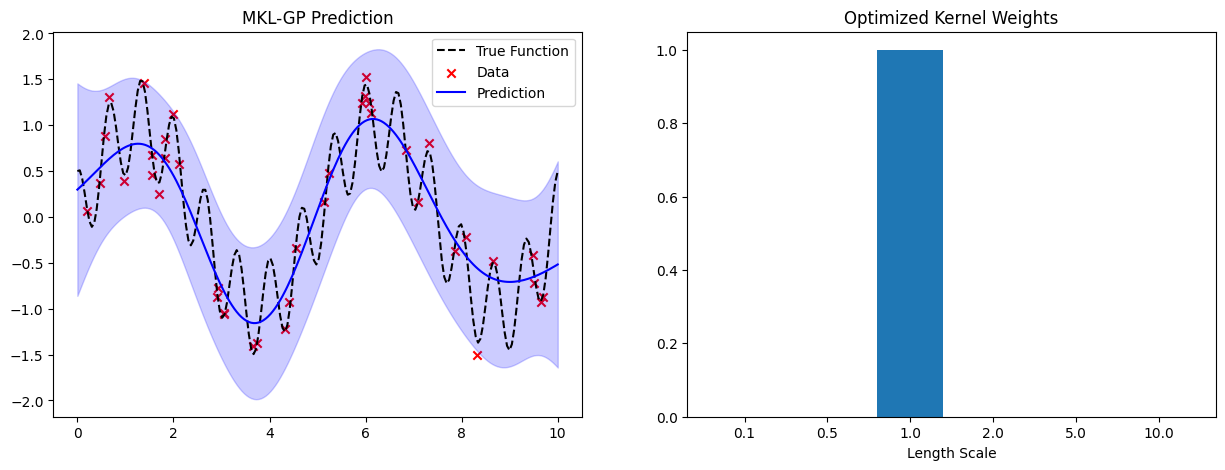

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

class LegendreSimplexOptimizer:
    """
    Legendre Decomposition for Tensors (Sugiyama et al.) の枠組みを用いた
    確率単体（Simplex）上の自然勾配法オプティマイザ。
    """
    def __init__(self, n_kernels, learning_rate=0.1, damping=1e-5):
        self.n_kernels = n_kernels
        self.lr = learning_rate
        self.damping = damping
        self.theta = np.zeros(n_kernels)  # 自然パラメータ theta

    def softmax(self, theta):
        exp_theta = np.exp(theta - np.max(theta))
        return exp_theta / np.sum(exp_theta)

    def get_weights(self):
        return self.softmax(self.theta)

    def compute_fisher_matrix(self, w):
        # Fisher Information Matrix G = diag(w) - w * w^T
        G = np.diag(w) - np.outer(w, w)
        return G

    def step(self, grad_w):
        w = self.get_weights()
        G = self.compute_fisher_matrix(w)
        
        # Chain Rule: dL/dtheta = G @ dL/dw
        grad_theta = G @ grad_w
        
        # Natural Gradient: G^{-1} @ grad_theta
        # SoftmaxのGはランク落ちするため pinv を使用（論文の理論的枠組みと整合）
        nat_grad = np.linalg.pinv(G) @ grad_theta
        
        # Update
        self.theta -= self.lr * nat_grad

class RBFKernel:
    def __init__(self, length_scale=1.0, variance=1.0):
        self.length_scale = length_scale
        self.variance = variance

    def __call__(self, X1, X2=None):
        if X2 is None:
            X2 = X1
        dists = cdist(X1 / self.length_scale, X2 / self.length_scale, metric='sqeuclidean')
        return self.variance * np.exp(-0.5 * dists)

class MKLGaussianProcess:
    def __init__(self, kernels, noise_level=0.1, optimizer_lr=0.1):
        self.kernels = kernels
        self.n_kernels = len(kernels)
        self.noise_level = noise_level
        # Simplex NGD Optimizer
        self.optimizer = LegendreSimplexOptimizer(self.n_kernels, learning_rate=optimizer_lr)
        self.X_train = None
        self.y_train = None
        self.K_inv = None
        self.L = None # Cholesky factor
        self.alpha = None

    def compute_combined_kernel(self, X1, X2=None):
        weights = self.optimizer.get_weights()
        K_combined = np.zeros((X1.shape[0], X2.shape[0] if X2 is not None else X1.shape[0]))
        for w, k in zip(weights, self.kernels):
            K_combined += w * k(X1, X2)
        return K_combined

    def fit_step(self, X, y):
        self.X_train = X
        self.y_train = y
        weights = self.optimizer.get_weights()
        
        # 1. 各基底カーネル行列の計算
        Ks = [k(X) for k in self.kernels]
        
        # 2. 合成カーネルの計算
        K = np.zeros((X.shape[0], X.shape[0]))
        for w, K_i in zip(weights, Ks):
            K += w * K_i
            
        # ノイズ付加
        K_noise = K + self.noise_level**2 * np.eye(len(X))
        
        # 3. Cholesky分解 (安定性のため)
        try:
            L = np.linalg.cholesky(K_noise)
        except np.linalg.LinAlgError:
            L = np.linalg.cholesky(K_noise + 1e-6 * np.eye(len(X)))
            
        # 4. 対数周辺尤度 (NLML) の計算
        # alpha = K^{-1} y
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        self.alpha = alpha
        self.L = L
        
        nlml = 0.5 * y.T @ alpha + np.sum(np.log(np.diag(L))) + 0.5 * len(X) * np.log(2 * np.pi)
        
        # 5. 重み w に関する勾配の計算
        # d(NLML)/dw_j = 0.5 * tr( (K^{-1} - alpha alpha^T) * K_j )
        K_inv = np.linalg.solve(L.T, np.linalg.solve(L, np.eye(len(X))))
        self.K_inv = K_inv
        
        grad_weights = np.zeros(self.n_kernels)
        inner_matrix = K_inv - np.outer(alpha, alpha)
        
        for i in range(self.n_kernels):
            grad_weights[i] = 0.5 * np.sum(inner_matrix * Ks[i])
            
        # 6. Legendre Simplex Optimizer で更新
        self.optimizer.step(grad_weights)
        
        return nlml.item()

    def predict(self, X_test):
        # 予測分布の平均と分散を計算
        K_trans = self.compute_combined_kernel(X_test, self.X_train)
        K_test = self.compute_combined_kernel(X_test, X_test)
        
        mu = K_trans @ self.alpha
        v = np.linalg.solve(self.L, K_trans.T)
        cov = K_test - v.T @ v
        
        return mu, np.diag(cov)

# --- 実験設定 ---
np.random.seed(42)

# データの生成 (高周波と低周波の混合)
def true_func(x):
    return np.sin(2 * np.pi * 0.2 * x) + 0.5 * np.cos(2 * np.pi * 1.5 * x)

X_train = np.random.uniform(0, 10, 40).reshape(-1, 1)
y_train = true_func(X_train).flatten() + np.random.normal(0, 0.1, 40)
X_test = np.linspace(0, 10, 200).reshape(-1, 1)
y_true = true_func(X_test).flatten()

# 候補カーネルの準備 (様々な長さスケール)
kernel_configs = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0] 
kernels = [RBFKernel(length_scale=ls) for ls in kernel_configs]

# MKL-GPの初期化と学習
mkl_gp = MKLGaussianProcess(kernels, noise_level=1, optimizer_lr=0.5)

print("Training...")
for i in range(50):
    loss = mkl_gp.fit_step(X_train, y_train)

# 結果のプロット
mu, var = mkl_gp.predict(X_test)
std = np.sqrt(var)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test, y_true, 'k--', label='True Function')
plt.scatter(X_train, y_train, c='r', marker='x', label='Data')
plt.plot(X_test, mu, 'b-', label='Prediction')
plt.fill_between(X_test.flatten(), mu - 2*std, mu + 2*std, color='b', alpha=0.2)
plt.title('MKL-GP Prediction')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(range(len(kernel_configs)), mkl_gp.optimizer.get_weights())
plt.xticks(range(len(kernel_configs)), kernel_configs)
plt.title('Optimized Kernel Weights')
plt.xlabel('Length Scale')
plt.show()

Starting Alternating Optimization...
Outer 0: NLML=-3.486, Weights=[0.   0.98 0.02]
Outer 5: NLML=-3.848, Weights=[0. 1. 0.]
Outer 10: NLML=-3.848, Weights=[0. 1. 0.]
Outer 15: NLML=-3.848, Weights=[0. 1. 0.]


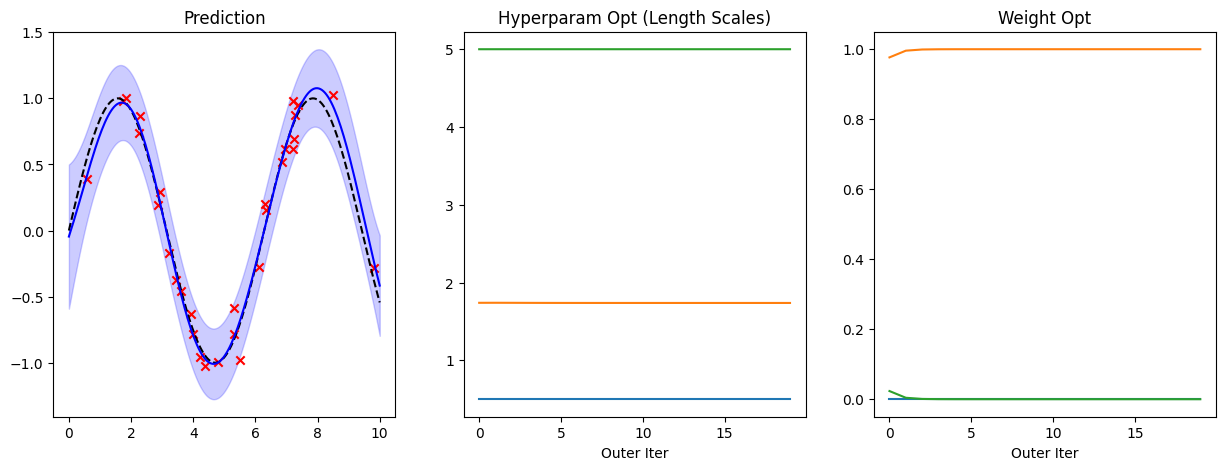

Final Length Scales: [np.float64(0.4999999999999754), np.float64(1.737925015317624), np.float64(5.000731758350912)]
Final Weights: [1.49578021e-36 1.00000000e+00 7.42477665e-16]


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# --- Helper Functions ---
def softmax(theta):
    exp_theta = np.exp(theta - np.max(theta))
    return exp_theta / np.sum(exp_theta)

class LegendreSimplexOptimizer:
    """Natural Gradient Optimizer for Simplex Weights."""
    def __init__(self, n_kernels, learning_rate=0.1):
        self.n_kernels = n_kernels
        self.lr = learning_rate
        self.theta = np.zeros(n_kernels)

    def get_weights(self):
        return softmax(self.theta)

    def step(self, grad_w):
        w = self.get_weights()
        # Fisher Matrix G = diag(w) - w w^T
        G = np.diag(w) - np.outer(w, w)
        
        # dL/dtheta = G @ dL/dw
        grad_theta = G @ grad_w
        
        # Natural Gradient direction: pinv(G) @ grad_theta
        nat_grad = np.linalg.pinv(G) @ grad_theta
        
        self.theta -= self.lr * nat_grad

class DifferentiableRBFKernel:
    """RBF Kernel supporting gradients w.r.t length_scale."""
    def __init__(self, initial_length_scale=1.0, initial_variance=1.0):
        # パラメータは対数空間で保持（正値性保証のため）
        self.log_length_scale = np.log(initial_length_scale)
        self.log_variance = np.log(initial_variance)

    @property
    def length_scale(self):
        return np.exp(self.log_length_scale)

    @property
    def variance(self):
        return np.exp(self.log_variance)

    def __call__(self, X1, X2=None):
        if X2 is None:
            X2 = X1
        dists = cdist(X1, X2, metric='sqeuclidean')
        K = self.variance * np.exp(-0.5 * dists / (self.length_scale ** 2))
        return K

    def gradient(self, X):
        """
        Computes dK/d(log_length_scale).
        Chain rule: dK/d(log_ell) = dK/dell * dell/dlog_ell
                                  = (K * dists / ell^3) * ell
                                  = K * dists / ell^2
        """
        dists = cdist(X, X, metric='sqeuclidean')
        K = self(X)
        grad_log_ls = K * (dists / (self.length_scale ** 2))
        return grad_log_ls

class AlternatingMKLGP:
    def __init__(self, initial_kernels, initial_noise=0.1, lr_weights=0.1, lr_hyper=0.01):
        self.kernels = initial_kernels
        self.n_kernels = len(initial_kernels)
        
        # Optimizers
        self.weight_optimizer = LegendreSimplexOptimizer(self.n_kernels, learning_rate=lr_weights)
        self.hyper_lr = lr_hyper
        
        # Hyperparam: log noise variance
        self.log_noise_var = np.log(initial_noise**2)
        
        self.X_train = None
        self.y_train = None
        
    @property
    def noise_variance(self):
        return np.exp(self.log_noise_var)

    def _compute_kernel_matrices(self, X):
        return [k(X) for k in self.kernels]

    def _compute_total_kernel(self, Ks, weights):
        K = np.zeros_like(Ks[0])
        for w, K_i in zip(weights, Ks):
            K += w * K_i
        return K

    def _inference(self, K_total):
        # Add noise
        K_noise = K_total + self.noise_variance * np.eye(len(K_total))
        
        # Cholesky Decomposition
        try:
            L = np.linalg.cholesky(K_noise)
        except np.linalg.LinAlgError:
            L = np.linalg.cholesky(K_noise + 1e-5 * np.eye(len(K_total)))
            
        # alpha = K^{-1} y
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, self.y_train))
        
        # NLML
        nlml = 0.5 * self.y_train.T @ alpha + np.sum(np.log(np.diag(L))) + 0.5 * len(self.y_train) * np.log(2 * np.pi)
        
        return L, alpha, nlml

    def fit(self, X, y, n_outer=20, n_inner_weights=5, n_inner_hyper=5):
        self.X_train = X
        self.y_train = y
        history = {'nlml': [], 'weights': [], 'length_scales': []}

        print("Starting Alternating Optimization...")
        
        for outer in range(n_outer):
            # --- Phase 1: Optimize Weights (w) ---
            Ks = self._compute_kernel_matrices(X) # ハイパラ固定なので事前計算
            
            for _ in range(n_inner_weights):
                weights = self.weight_optimizer.get_weights()
                K_total = self._compute_total_kernel(Ks, weights)
                L, alpha, _ = self._inference(K_total)
                
                # 重みの勾配計算
                K_inv = np.linalg.solve(L.T, np.linalg.solve(L, np.eye(len(X))))
                Q = K_inv - np.outer(alpha, alpha)
                grad_w = np.array([0.5 * np.sum(Q * K_j) for K_j in Ks])
                
                self.weight_optimizer.step(grad_w)

            # --- Phase 2: Optimize Hyperparameters ---
            # ここでは length_scale と noise_level を更新
            for _ in range(n_inner_hyper):
                weights = self.weight_optimizer.get_weights()
                
                # ハイパラが変わるのでカーネル行列を再計算
                Ks = self._compute_kernel_matrices(X)
                K_total = self._compute_total_kernel(Ks, weights)
                
                L, alpha, nlml = self._inference(K_total)
                history['nlml'].append(nlml.item())
                
                # 勾配の共通項 Q = dL/dK
                K_inv = np.linalg.solve(L.T, np.linalg.solve(L, np.eye(len(X))))
                Q = K_inv - np.outer(alpha, alpha)
                
                # 1. Length Scales の勾配更新
                for i, kernel in enumerate(self.kernels):
                    dK_dlg = kernel.gradient(X)
                    # 合成カーネルに対する寄与: w_i * dK_i/d(log_ell)
                    grad_log_ls = 0.5 * np.sum(Q * (weights[i] * dK_dlg))
                    kernel.log_length_scale -= self.hyper_lr * grad_log_ls

                # 2. Noise Variance の勾配更新
                grad_log_noise = 0.5 * np.trace(Q) * self.noise_variance
                self.log_noise_var -= self.hyper_lr * grad_log_noise
            
            # 履歴記録
            current_ls = [k.length_scale for k in self.kernels]
            history['length_scales'].append(current_ls)
            history['weights'].append(self.weight_optimizer.get_weights())
            
            if outer % 5 == 0:
                print(f"Outer {outer}: NLML={nlml.item():.3f}, Weights={np.round(weights, 2)}")

        return history

    def predict(self, X_test):
        weights = self.weight_optimizer.get_weights()
        Ks = self._compute_kernel_matrices(self.X_train)
        K_total = self._compute_total_kernel(Ks, weights)
        L, alpha, _ = self._inference(K_total)
        
        Ks_star = [k(X_test, self.X_train) for k in self.kernels]
        K_star = self._compute_total_kernel(Ks_star, weights)
        
        Ks_star2 = [k(X_test, X_test) for k in self.kernels]
        K_star2 = self._compute_total_kernel(Ks_star2, weights)
        
        mu = K_star @ alpha
        v = np.linalg.solve(L, K_star.T)
        var = np.diag(K_star2) - np.sum(v**2, axis=0) + self.noise_variance
        
        return mu, var

# --- Run Experiment ---
np.random.seed(123)
X_train = np.random.uniform(0, 10, 30).reshape(-1, 1)
y_train = np.sin(X_train).flatten() + np.random.normal(0, 0.1, 30)
X_test = np.linspace(0, 10, 200).reshape(-1, 1)

# 初期長さスケールを変えて3つのカーネルを用意
kernels = [DifferentiableRBFKernel(ls) for ls in [0.5, 2.0, 5.0]]
model = AlternatingMKLGP(kernels, lr_weights=0.2, lr_hyper=0.01)

history = model.fit(X_train, y_train, n_outer=20)

mu, var = model.predict(X_test)
std = np.sqrt(var)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(X_test, np.sin(X_test), 'k--', label="True")
plt.plot(X_test, mu, 'b-', label="Pred")
plt.fill_between(X_test.flatten(), mu-2*std, mu+2*std, color='b', alpha=0.2)
plt.scatter(X_train, y_train, c='r', marker='x')
plt.title("Prediction")

plt.subplot(1, 3, 2)
plt.plot(history['length_scales'])
plt.title("Hyperparam Opt (Length Scales)")
plt.xlabel("Outer Iter")

plt.subplot(1, 3, 3)
plt.plot(history['weights'])
plt.title("Weight Opt")
plt.xlabel("Outer Iter")
plt.show()

print("Final Length Scales:", [k.length_scale for k in model.kernels])
print("Final Weights:", model.weight_optimizer.get_weights())

Starting PyTorch Alternating Optimization (Double Precision)...
Outer 0: Loss=6.0100, Weights=[0.75 0.15 0.05 0.05], Length Scales=[ 0.51  1.98  5.05 10.1 ]
Outer 10: Loss=3.7583, Weights=[0.4  0.58 0.01 0.01], Length Scales=[ 0.55  1.8   5.5  10.56]
Outer 20: Loss=2.9148, Weights=[0.51 0.49 0.   0.  ], Length Scales=[ 0.6   1.64  5.71 10.42]
Outer 30: Loss=2.2292, Weights=[0.67 0.33 0.   0.  ], Length Scales=[ 0.66  1.52  5.8  10.34]
Outer 40: Loss=1.6669, Weights=[0.86 0.14 0.   0.  ], Length Scales=[ 0.71  1.45  5.83 10.3 ]


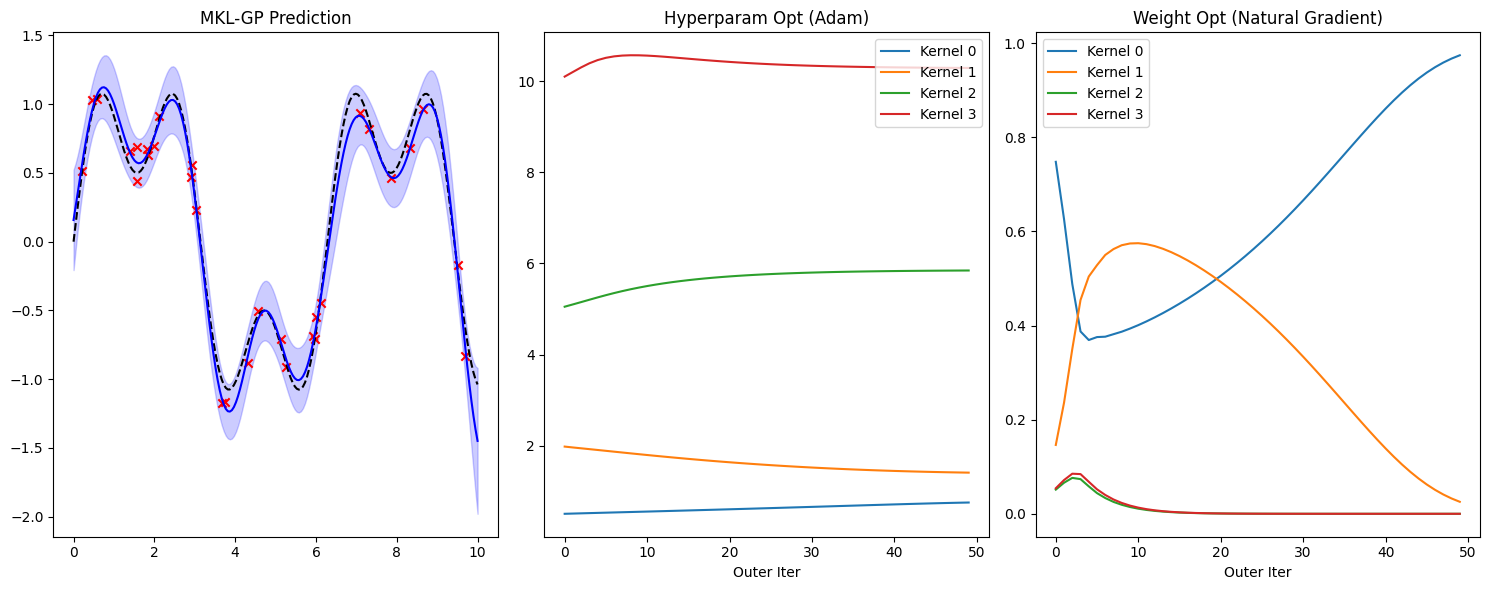

Final Weights: [0.9745 0.0255 0.     0.    ]
Final Length Scales: [ 0.7525  1.4083  5.8451 10.2904]


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# --- 0. Global Configuration ---
# ここでデータ型を一括定義 (Double precision for stability)
DTYPE = torch.float64
torch.set_default_dtype(DTYPE)

# --- 1. Custom Natural Gradient Optimizer for Simplex ---
class NaturalGradientSimplex(optim.Optimizer):
    """
    確率単体（Simplex）上のパラメータ（logits）に対する自然勾配法オプティマイザ。
    Legendre Decomposition (Sugiyama et al.) の幾何学構造を利用。
    """
    def __init__(self, params, lr=0.1, damping=1e-5):
        defaults = dict(lr=lr, damping=damping)
        super(NaturalGradientSimplex, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                # p は自然パラメータ theta (logits)
                # w = softmax(theta)
                w = torch.softmax(p, dim=0)
                
                # フィッシャー情報行列 G = diag(w) - w @ w.T
                G = torch.diag(w) - torch.outer(w, w)
                
                # 数値安定性のためのダンピング
                G.diagonal().add_(group['damping'])
                
                # 勾配 dL/dtheta (PyTorchのautogradで計算済み)
                grad_theta = p.grad
                
                # 自然勾配: inv(G) @ grad_theta
                # Gはランク落ちするため擬似逆行列(pinv)を使用
                nat_grad = torch.linalg.pinv(G) @ grad_theta
                
                # パラメータ更新
                p.sub_(group['lr'] * nat_grad)
                
        return loss

# --- 2. MKL Gaussian Process Model ---
class MKLGP(nn.Module):
    def __init__(self, n_kernels, initial_length_scales):
        super(MKLGP, self).__init__()
        
        # カーネルの重み (theta: logits) -> NGDで最適化
        self.theta = nn.Parameter(torch.zeros(n_kernels, dtype=DTYPE))
        
        # ハイパーパラメータ -> Adamで最適化
        # 正値制約のため log 空間で保持
        self.log_length_scales = nn.Parameter(
            torch.log(torch.tensor(initial_length_scales, dtype=DTYPE))
        )
        self.log_noise_var = nn.Parameter(
            torch.log(torch.tensor(0.1**2, dtype=DTYPE))
        )

    @property
    def weights(self):
        return torch.softmax(self.theta, dim=0)

    @property
    def length_scales(self):
        return torch.exp(self.log_length_scales)

    @property
    def noise_variance(self):
        return torch.exp(self.log_noise_var)

    def compute_kernel(self, X1, X2=None):
        if X2 is None: X2 = X1
        
        w = self.weights
        ls = self.length_scales
        
        # 距離行列: (Batch, N, M)
        dists_sq = torch.cdist(X1, X2, p=2)**2
        
        K_total = torch.zeros(X1.size(0), X2.size(0), dtype=DTYPE, device=X1.device)
        
        for i in range(len(w)):
            # LSのスケーリング
            scaled_dists = dists_sq / (ls[i]**2)
            K_i = torch.exp(-0.5 * scaled_dists)
            K_total += w[i] * K_i
            
        return K_total

    def negative_log_marginal_likelihood(self, X, y):
        K = self.compute_kernel(X)
        # ノイズを加算 (dtypeを明示)
        K_noise = K + self.noise_variance * torch.eye(X.size(0), dtype=DTYPE, device=X.device)
        
        try:
            mvn = torch.distributions.MultivariateNormal(torch.zeros_like(y), covariance_matrix=K_noise)
            return -mvn.log_prob(y)
        except ValueError:
            # 失敗した場合はジッターを追加してリトライ
            K_noise += 1e-6 * torch.eye(X.size(0), dtype=DTYPE, device=X.device)
            mvn = torch.distributions.MultivariateNormal(torch.zeros_like(y), covariance_matrix=K_noise)
            return -mvn.log_prob(y)

    def predict(self, X_train, y_train, X_test):
        self.eval()
        with torch.no_grad():
            K_tt = self.compute_kernel(X_train) + self.noise_variance * torch.eye(X_train.size(0), dtype=DTYPE, device=X_train.device)
            K_st = self.compute_kernel(X_test, X_train)
            K_ss = self.compute_kernel(X_test, X_test)
            
            # 平均: K_st @ K_tt^-1 @ y
            L = torch.linalg.cholesky(K_tt)
            alpha = torch.cholesky_solve(y_train.unsqueeze(1), L)
            mu = K_st @ alpha
            
            # 分散: K_ss - K_st @ K_tt^-1 @ K_st.T
            v = torch.linalg.solve(L, K_st.T)
            var = torch.diag(K_ss) - torch.sum(v**2, dim=0) + self.noise_variance
            
            return mu.squeeze(), var

# --- Experiment Setup ---
torch.manual_seed(42)
np.random.seed(42)

# データ生成
X_train_np = np.random.uniform(0, 10, 30).reshape(-1, 1)
y_train_np = (np.sin(X_train_np) + 0.5 * np.sin(3 * X_train_np)).flatten() + np.random.normal(0, 0.1, 30)
X_test_np = np.linspace(0, 10, 200).reshape(-1, 1)
y_true_np = (np.sin(X_test_np) + 0.5 * np.sin(3 * X_test_np)).flatten()

# Tensor変換 (DTYPEを使用)
X_train = torch.tensor(X_train_np, dtype=DTYPE)
y_train = torch.tensor(y_train_np, dtype=DTYPE)
X_test = torch.tensor(X_test_np, dtype=DTYPE)

# モデル初期化
initial_ls = [0.5, 2.0, 5.0, 10.0]
model = MKLGP(n_kernels=len(initial_ls), initial_length_scales=initial_ls)

# --- 交互最適化の設定 ---
# Optimizer 1: 重み (Theta) 用 -> Natural Gradient
optim_weights = NaturalGradientSimplex([model.theta], lr=0.2)

# Optimizer 2: ハイパーパラメータ (LengthScale, Noise) 用 -> Adam
optim_hyper = optim.Adam([model.log_length_scales, model.log_noise_var], lr=0.01)

history = {'loss': [], 'weights': [], 'length_scales': []}

print("Starting PyTorch Alternating Optimization (Double Precision)...")

n_outer = 50
n_inner_weights = 1
n_inner_hyper = 1

for outer in range(n_outer):
    # --- Phase 1: Optimize Weights (Natural Gradient) ---
    for _ in range(n_inner_weights):
        optim_weights.zero_grad()
        loss = model.negative_log_marginal_likelihood(X_train, y_train)
        loss.backward()
        optim_weights.step() # ここで G^-1 @ grad を実行

    # --- Phase 2: Optimize Hyperparameters (Adam) ---
    for _ in range(n_inner_hyper):
        optim_hyper.zero_grad()
        loss = model.negative_log_marginal_likelihood(X_train, y_train)
        loss.backward()
        optim_hyper.step()
        
    # 記録
    with torch.no_grad():
        current_loss = model.negative_log_marginal_likelihood(X_train, y_train).item()
        history['loss'].append(current_loss)
        history['weights'].append(model.weights.clone().numpy())
        history['length_scales'].append(model.length_scales.clone().numpy())
    
    if outer % 10 == 0:
        print(f"Outer {outer}: Loss={current_loss:.4f}, Weights={np.round(history['weights'][-1], 2)}, Length Scales={np.round(history['length_scales'][-1], 2)}")

# --- Visualization ---
mu, var = model.predict(X_train, y_train, X_test)
std = torch.sqrt(var).numpy()
mu = mu.numpy()

plt.figure(figsize=(15, 6))

# 予測結果
plt.subplot(1, 3, 1)
plt.plot(X_test_np, y_true_np, 'k--', label="True")
plt.plot(X_test_np, mu, 'b-', label="Prediction")
plt.fill_between(X_test_np.flatten(), mu - 2*std, mu + 2*std, color='b', alpha=0.2)
plt.scatter(X_train_np, y_train_np, c='r', marker='x')
plt.title("MKL-GP Prediction")

# 長さスケールの推移 (Adam)
plt.subplot(1, 3, 2)
ls_history = np.array(history['length_scales'])
for i in range(ls_history.shape[1]):
    plt.plot(ls_history[:, i], label=f"Kernel {i}")
plt.title("Hyperparam Opt (Adam)")
plt.xlabel("Outer Iter")
plt.legend()

# 重みの推移 (NGD)
plt.subplot(1, 3, 3)
w_history = np.array(history['weights'])
for i in range(w_history.shape[1]):
    plt.plot(w_history[:, i], label=f"Kernel {i}")
plt.title("Weight Opt (Natural Gradient)")
plt.xlabel("Outer Iter")
plt.legend()

plt.tight_layout()
plt.show()

print("Final Weights:", np.round(model.weights.detach().numpy(), 4))
print("Final Length Scales:", np.round(model.length_scales.detach().numpy(), 4))

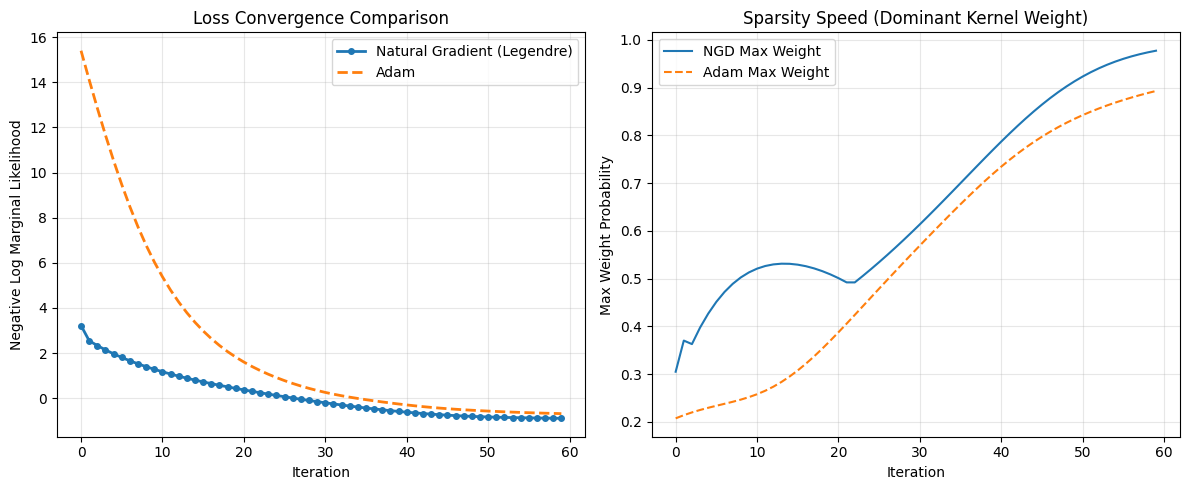

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# --- 0. Configuration ---
DTYPE = torch.float64
torch.set_default_dtype(DTYPE)

# --- 1. Optimizer & Model Classes (Previous definition) ---
class NaturalGradientSimplex(optim.Optimizer):
    def __init__(self, params, lr=0.1, damping=1e-5):
        defaults = dict(lr=lr, damping=damping)
        super(NaturalGradientSimplex, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue
                w = torch.softmax(p, dim=0)
                G = torch.diag(w) - torch.outer(w, w)
                G.diagonal().add_(group['damping'])
                grad_theta = p.grad
                nat_grad = torch.linalg.pinv(G) @ grad_theta
                p.sub_(group['lr'] * nat_grad)
        return loss

class MKLGP(nn.Module):
    def __init__(self, n_kernels, initial_length_scales):
        super(MKLGP, self).__init__()
        self.theta = nn.Parameter(torch.zeros(n_kernels, dtype=DTYPE))
        self.log_length_scales = nn.Parameter(torch.log(torch.tensor(initial_length_scales, dtype=DTYPE)))
        self.log_noise_var = nn.Parameter(torch.log(torch.tensor(0.1**2, dtype=DTYPE)))

    @property
    def weights(self):
        return torch.softmax(self.theta, dim=0)
    
    @property
    def length_scales(self):
        return torch.exp(self.log_length_scales)
    
    @property
    def noise_variance(self):
        return torch.exp(self.log_noise_var)

    def compute_kernel(self, X1, X2=None):
        if X2 is None: X2 = X1
        w = self.weights
        ls = self.length_scales
        dists_sq = torch.cdist(X1, X2, p=2)**2
        K_total = torch.zeros(X1.size(0), X2.size(0), dtype=DTYPE, device=X1.device)
        for i in range(len(w)):
            K_total += w[i] * torch.exp(-0.5 * dists_sq / (ls[i]**2))
        return K_total

    def negative_log_marginal_likelihood(self, X, y):
        K = self.compute_kernel(X)
        K_noise = K + self.noise_variance * torch.eye(X.size(0), device=X.device)
        # Numerical stability fallback
        try:
            mvn = torch.distributions.MultivariateNormal(torch.zeros_like(y), covariance_matrix=K_noise)
        except ValueError:
            K_noise += 1e-5 * torch.eye(X.size(0), device=X.device)
            mvn = torch.distributions.MultivariateNormal(torch.zeros_like(y), covariance_matrix=K_noise)
        return -mvn.log_prob(y)

# --- 2. Training Function ---
def train_model(optimizer_type, X_train, y_train, n_iter=60):
    # Reset seeds for fair comparison
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Initialize Model
    initial_ls = [0.1, 0.5, 2.0, 5.0, 10.0]
    model = MKLGP(n_kernels=len(initial_ls), initial_length_scales=initial_ls)
    
    # Setup Optimizers
    lr_weights = 0.1 # Same LR for fair comparison
    
    if optimizer_type == 'NGD':
        # Weights: Natural Gradient
        optim_weights = NaturalGradientSimplex([model.theta], lr=lr_weights)
    elif optimizer_type == 'Adam':
        # Weights: Adam
        optim_weights = optim.Adam([model.theta], lr=lr_weights)
    
    # Hyperparams: Always Adam
    optim_hyper = optim.Adam([model.log_length_scales, model.log_noise_var], lr=0.01)
    
    loss_history = []
    weights_history = []
    
    # Alternating Optimization Loop
    for i in range(n_iter):
        # 1. Update Weights
        optim_weights.zero_grad()
        loss = model.negative_log_marginal_likelihood(X_train, y_train)
        loss.backward()
        optim_weights.step()
        
        # 2. Update Hyperparams
        optim_hyper.zero_grad()
        loss = model.negative_log_marginal_likelihood(X_train, y_train)
        loss.backward()
        optim_hyper.step()
        
        # Record
        with torch.no_grad():
            loss_val = model.negative_log_marginal_likelihood(X_train, y_train).item()
            loss_history.append(loss_val)
            weights_history.append(model.weights.clone().detach().numpy())
            
    return loss_history, np.array(weights_history)

# --- 3. Main Experiment ---
# Data Generation
torch.manual_seed(42)
X_train_np = np.random.uniform(0, 10, 40).reshape(-1, 1)
y_train_np = (np.sin(X_train_np) + 0.5 * np.sin(3 * X_train_np)).flatten() + np.random.normal(0, 0.1, 40)
X_train = torch.tensor(X_train_np, dtype=DTYPE)
y_train = torch.tensor(y_train_np, dtype=DTYPE)

# Run Comparison
loss_ngd, weights_ngd = train_model('NGD', X_train, y_train)
loss_adam, weights_adam = train_model('Adam', X_train, y_train)

# --- 4. Visualization ---
plt.figure(figsize=(12, 5))

# Plot 1: Loss Curve Comparison
plt.subplot(1, 2, 1)
plt.plot(loss_ngd, label='Natural Gradient (Legendre)', linewidth=2, marker='o', markersize=4)
plt.plot(loss_adam, label='Adam', linewidth=2, linestyle='--')
plt.title('Loss Convergence Comparison')
plt.xlabel('Iteration')
plt.ylabel('Negative Log Marginal Likelihood')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 2: Sparsity Evolution (Max Weight)
# Shows how quickly the optimizer identifies the "best" kernel
plt.subplot(1, 2, 2)
plt.plot(np.max(weights_ngd, axis=1), label='NGD Max Weight', color='tab:blue')
plt.plot(np.max(weights_adam, axis=1), label='Adam Max Weight', color='tab:orange', linestyle='--')
plt.title('Sparsity Speed (Dominant Kernel Weight)')
plt.xlabel('Iteration')
plt.ylabel('Max Weight Probability')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

Starting Optimization (Learning Noise Variance)...
Iter 0: Loss=11.002, NoiseStd=0.199
Iter 10: Loss=9.346, NoiseStd=0.189
Iter 20: Loss=8.493, NoiseStd=0.180
Iter 30: Loss=7.731, NoiseStd=0.171
Iter 40: Loss=6.997, NoiseStd=0.163
Iter 50: Loss=6.312, NoiseStd=0.155
Iter 60: Loss=5.712, NoiseStd=0.147
Iter 70: Loss=5.175, NoiseStd=0.140
Iter 80: Loss=4.683, NoiseStd=0.134
Iter 90: Loss=4.230, NoiseStd=0.128


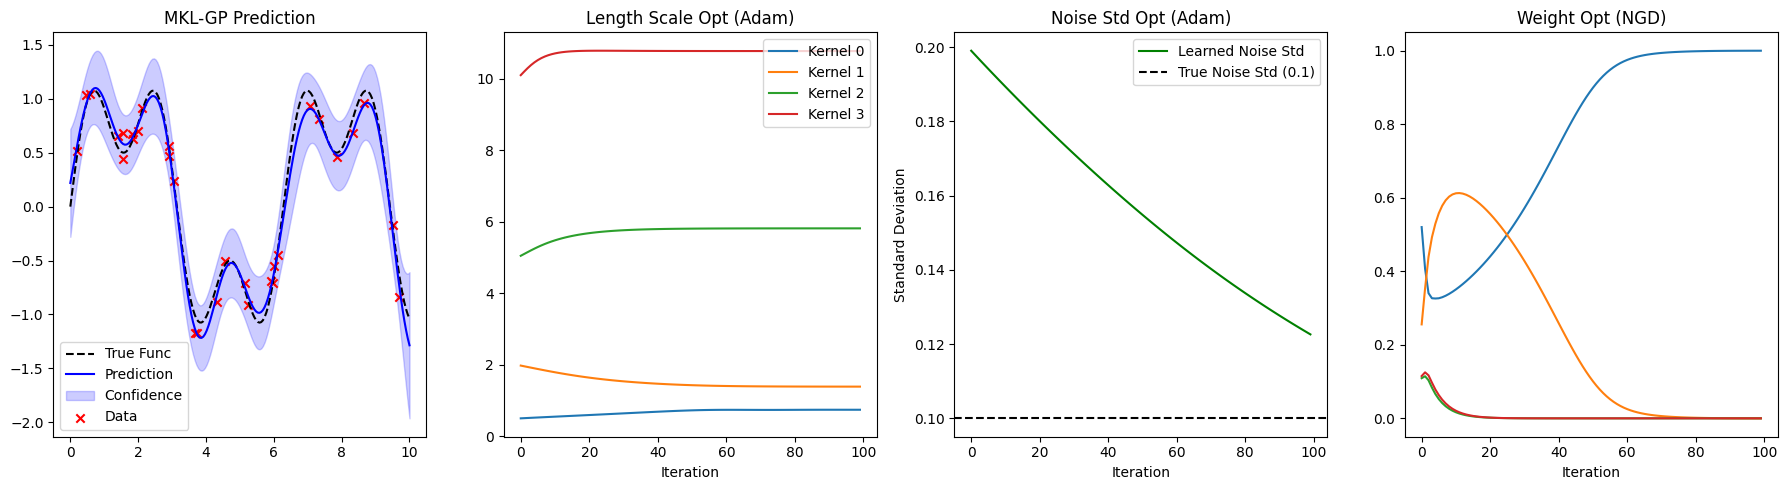

Final Noise Std: 0.1226
True Noise Std:  0.1


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# --- 0. Global Configuration ---
# 数値安定性のため倍精度 (Double) を使用
DTYPE = torch.float64
torch.set_default_dtype(DTYPE)

# --- 1. Custom Natural Gradient Optimizer for Simplex ---
class NaturalGradientSimplex(optim.Optimizer):
    """
    確率単体（Simplex）上のパラメータ（logits）に対する自然勾配法オプティマイザ。
    Legendre Decomposition (Sugiyama et al.) の幾何学構造を利用。
    """
    def __init__(self, params, lr=0.1, damping=1e-5):
        defaults = dict(lr=lr, damping=damping)
        super(NaturalGradientSimplex, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                # p は自然パラメータ theta (logits)
                w = torch.softmax(p, dim=0)
                
                # フィッシャー情報行列 G = diag(w) - w @ w.T
                G = torch.diag(w) - torch.outer(w, w)
                G.diagonal().add_(group['damping'])
                
                grad_theta = p.grad
                
                # 自然勾配: inv(G) @ grad_theta
                nat_grad = torch.linalg.pinv(G) @ grad_theta
                
                p.sub_(group['lr'] * nat_grad)
                
        return loss

# --- 2. MKL Gaussian Process Model ---
class MKLGP(nn.Module):
    def __init__(self, n_kernels, initial_length_scales, initial_noise_std=0.1):
        super(MKLGP, self).__init__()
        
        # 1. カーネル重み (Theta: logits) -> NGDで最適化
        self.theta = nn.Parameter(torch.zeros(n_kernels, dtype=DTYPE))
        
        # 2. カーネル長スケール -> Adamで最適化 (log空間)
        self.log_length_scales = nn.Parameter(
            torch.log(torch.tensor(initial_length_scales, dtype=DTYPE))
        )
        
        # 3. ガウスノイズ分散 -> Adamで最適化 (log空間)
        # ここで初期値を設定し、学習可能パラメータ(nn.Parameter)として登録
        self.log_noise_var = nn.Parameter(
            torch.log(torch.tensor(initial_noise_std**2, dtype=DTYPE))
        )

    @property
    def weights(self):
        return torch.softmax(self.theta, dim=0)

    @property
    def length_scales(self):
        return torch.exp(self.log_length_scales)

    @property
    def noise_variance(self):
        return torch.exp(self.log_noise_var)

    def compute_kernel(self, X1, X2=None):
        if X2 is None: X2 = X1
        
        w = self.weights
        ls = self.length_scales
        
        dists_sq = torch.cdist(X1, X2, p=2)**2
        
        K_total = torch.zeros(X1.size(0), X2.size(0), dtype=DTYPE, device=X1.device)
        
        for i in range(len(w)):
            scaled_dists = dists_sq / (ls[i]**2)
            K_i = torch.exp(-0.5 * scaled_dists)
            K_total += w[i] * K_i
            
        return K_total

    def negative_log_marginal_likelihood(self, X, y):
        K = self.compute_kernel(X)
        # 学習されたノイズ分散を使用
        K_noise = K + self.noise_variance * torch.eye(X.size(0), dtype=DTYPE, device=X.device)
        
        try:
            mvn = torch.distributions.MultivariateNormal(torch.zeros_like(y), covariance_matrix=K_noise)
            return -mvn.log_prob(y)
        except ValueError:
            # 数値安定性のためのフォールバック
            K_noise += 1e-6 * torch.eye(X.size(0), dtype=DTYPE, device=X.device)
            mvn = torch.distributions.MultivariateNormal(torch.zeros_like(y), covariance_matrix=K_noise)
            return -mvn.log_prob(y)

    def predict(self, X_train, y_train, X_test):
        self.eval()
        with torch.no_grad():
            K_tt = self.compute_kernel(X_train) + self.noise_variance * torch.eye(X_train.size(0), dtype=DTYPE, device=X_train.device)
            K_st = self.compute_kernel(X_test, X_train)
            K_ss = self.compute_kernel(X_test, X_test)
            
            L = torch.linalg.cholesky(K_tt)
            alpha = torch.cholesky_solve(y_train.unsqueeze(1), L)
            mu = K_st @ alpha
            
            v = torch.linalg.solve(L, K_st.T)
            var = torch.diag(K_ss) - torch.sum(v**2, dim=0) + self.noise_variance
            
            return mu.squeeze(), var

# --- Experiment Setup ---
torch.manual_seed(42)
np.random.seed(42)

# データ生成 (真のノイズ標準偏差 = 0.1)
TRUE_NOISE_STD = 0.1
X_train_np = np.random.uniform(0, 10, 30).reshape(-1, 1)
y_train_np = (np.sin(X_train_np) + 0.5 * np.sin(3 * X_train_np)).flatten() + np.random.normal(0, TRUE_NOISE_STD, 30)
X_test_np = np.linspace(0, 10, 200).reshape(-1, 1)
y_true_np = (np.sin(X_test_np) + 0.5 * np.sin(3 * X_test_np)).flatten()

# Tensor変換
X_train = torch.tensor(X_train_np, dtype=DTYPE)
y_train = torch.tensor(y_train_np, dtype=DTYPE)
X_test = torch.tensor(X_test_np, dtype=DTYPE)

# モデル初期化 (初期ノイズはあえて大きく設定して学習されるか確認: 0.5)
initial_ls = [0.5, 2.0, 5.0, 10.0]
model = MKLGP(n_kernels=len(initial_ls), initial_length_scales=initial_ls, initial_noise_std=0.2)

# --- 交互最適化の設定 ---
# Optimizer 1: 重み (Theta) -> Natural Gradient
optim_weights = NaturalGradientSimplex([model.theta], lr=0.2)

# Optimizer 2: ハイパーパラメータ (LengthScale, Noise) -> Adam
# ここで model.log_noise_var も Adam の管理下に含めます
optim_hyper = optim.Adam([model.log_length_scales, model.log_noise_var], lr=0.01)

history = {'loss': [], 'weights': [], 'length_scales': [], 'noise_std': []}

print("Starting Optimization (Learning Noise Variance)...")

n_outer = 100
n_inner_weights = 1
n_inner_hyper = 1

for outer in range(n_outer):
    # Phase 1: Optimize Weights (Natural Gradient)
    for _ in range(n_inner_weights):
        optim_weights.zero_grad()
        loss = model.negative_log_marginal_likelihood(X_train, y_train)
        loss.backward()
        optim_weights.step()

    # Phase 2: Optimize Hyperparameters (Adam)
    for _ in range(n_inner_hyper):
        optim_hyper.zero_grad()
        loss = model.negative_log_marginal_likelihood(X_train, y_train)
        loss.backward()
        optim_hyper.step()
        
    # 記録
    with torch.no_grad():
        current_loss = model.negative_log_marginal_likelihood(X_train, y_train).item()
        history['loss'].append(current_loss)
        history['weights'].append(model.weights.clone().numpy())
        history['length_scales'].append(model.length_scales.clone().numpy())
        # ノイズの標準偏差 (sqrt(variance)) を記録
        history['noise_std'].append(np.sqrt(model.noise_variance.item()))
    
    if outer % 10 == 0:
        print(f"Iter {outer}: Loss={current_loss:.3f}, NoiseStd={history['noise_std'][-1]:.3f}")

# --- Visualization ---
mu, var = model.predict(X_train, y_train, X_test)
std = torch.sqrt(var).numpy()
mu = mu.numpy()

plt.figure(figsize=(18, 5))

# 1. 予測結果
plt.subplot(1, 4, 1)
plt.plot(X_test_np, y_true_np, 'k--', label="True Func")
plt.plot(X_test_np, mu, 'b-', label="Prediction")
plt.fill_between(X_test_np.flatten(), mu - 2*std, mu + 2*std, color='b', alpha=0.2, label="Confidence")
plt.scatter(X_train_np, y_train_np, c='r', marker='x', label="Data")
plt.title("MKL-GP Prediction")
plt.legend()

# 2. 長さスケールの推移
plt.subplot(1, 4, 2)
ls_history = np.array(history['length_scales'])
for i in range(ls_history.shape[1]):
    plt.plot(ls_history[:, i], label=f"Kernel {i}")
plt.title("Length Scale Opt (Adam)")
plt.xlabel("Iteration")
plt.legend()

# 3. ノイズ分散の推移 (New!)
plt.subplot(1, 4, 3)
plt.plot(history['noise_std'], color='green', label='Learned Noise Std')
plt.axhline(y=TRUE_NOISE_STD, color='k', linestyle='--', label='True Noise Std (0.1)')
plt.title("Noise Std Opt (Adam)")
plt.xlabel("Iteration")
plt.ylabel("Standard Deviation")
plt.legend()

# 4. カーネル重みの推移
plt.subplot(1, 4, 4)
w_history = np.array(history['weights'])
for i in range(w_history.shape[1]):
    plt.plot(w_history[:, i], label=f"Kernel {i}")
plt.title("Weight Opt (NGD)")
plt.xlabel("Iteration")

plt.tight_layout()
plt.show()

print("Final Noise Std:", np.round(np.sqrt(model.noise_variance.item()), 4))
print("True Noise Std: ", TRUE_NOISE_STD)

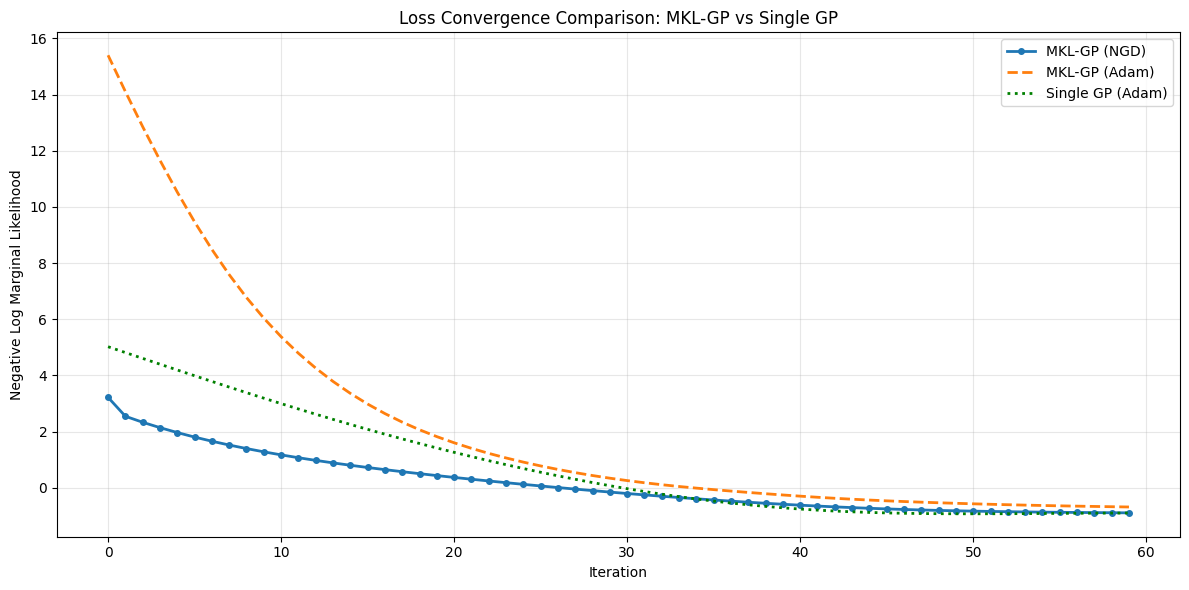

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# --- 0. Configuration ---
DTYPE = torch.float64
torch.set_default_dtype(DTYPE)

# --- 1. Optimizer & Model Classes ---
class NaturalGradientSimplex(optim.Optimizer):
    def __init__(self, params, lr=0.1, damping=1e-5):
        defaults = dict(lr=lr, damping=damping)
        super(NaturalGradientSimplex, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue
                w = torch.softmax(p, dim=0)
                G = torch.diag(w) - torch.outer(w, w)
                G.diagonal().add_(group['damping'])
                grad_theta = p.grad
                nat_grad = torch.linalg.pinv(G) @ grad_theta
                p.sub_(group['lr'] * nat_grad)
        return loss

class MKLGP(nn.Module):
    def __init__(self, n_kernels, initial_length_scales):
        super(MKLGP, self).__init__()
        self.theta = nn.Parameter(torch.zeros(n_kernels, dtype=DTYPE))
        self.log_length_scales = nn.Parameter(torch.log(torch.tensor(initial_length_scales, dtype=DTYPE)))
        self.log_noise_var = nn.Parameter(torch.log(torch.tensor(0.1**2, dtype=DTYPE)))

    @property
    def weights(self):
        return torch.softmax(self.theta, dim=0)
    
    @property
    def length_scales(self):
        return torch.exp(self.log_length_scales)
    
    @property
    def noise_variance(self):
        return torch.exp(self.log_noise_var)

    def compute_kernel(self, X1, X2=None):
        if X2 is None: X2 = X1
        w = self.weights
        ls = self.length_scales
        dists_sq = torch.cdist(X1, X2, p=2)**2
        K_total = torch.zeros(X1.size(0), X2.size(0), dtype=DTYPE, device=X1.device)
        for i in range(len(w)):
            K_total += w[i] * torch.exp(-0.5 * dists_sq / (ls[i]**2))
        return K_total

    def negative_log_marginal_likelihood(self, X, y):
        K = self.compute_kernel(X)
        K_noise = K + self.noise_variance * torch.eye(X.size(0), device=X.device)
        try:
            mvn = torch.distributions.MultivariateNormal(torch.zeros_like(y), covariance_matrix=K_noise)
        except ValueError:
            K_noise += 1e-5 * torch.eye(X.size(0), device=X.device)
            mvn = torch.distributions.MultivariateNormal(torch.zeros_like(y), covariance_matrix=K_noise)
        return -mvn.log_prob(y)

class SingleGP(nn.Module):
    def __init__(self, initial_length_scale=0.5):
        super(SingleGP, self).__init__()
        self.log_length_scale = nn.Parameter(torch.log(torch.tensor(initial_length_scale, dtype=DTYPE)))
        self.log_noise_var = nn.Parameter(torch.log(torch.tensor(0.1**2, dtype=DTYPE)))

    @property
    def length_scale(self):
        return torch.exp(self.log_length_scale)

    @property
    def noise_variance(self):
        return torch.exp(self.log_noise_var)

    def compute_kernel(self, X1, X2=None):
        if X2 is None: X2 = X1
        ls = self.length_scale
        dists_sq = torch.cdist(X1, X2, p=2)**2
        K = torch.exp(-0.5 * dists_sq / (ls**2))
        return K

    def negative_log_marginal_likelihood(self, X, y):
        K = self.compute_kernel(X)
        K_noise = K + self.noise_variance * torch.eye(X.size(0), device=X.device)
        try:
            mvn = torch.distributions.MultivariateNormal(torch.zeros_like(y), covariance_matrix=K_noise)
        except ValueError:
            K_noise += 1e-5 * torch.eye(X.size(0), device=X.device)
            mvn = torch.distributions.MultivariateNormal(torch.zeros_like(y), covariance_matrix=K_noise)
        return -mvn.log_prob(y)

# --- 2. Training Function ---
def train_model(model_type, X_train, y_train, n_iter=60):
    torch.manual_seed(42)
    np.random.seed(42)
    
    loss_history = []
    
    if model_type == 'Single':
        # Single GP setup
        model = SingleGP(initial_length_scale=0.5) # Start with a reasonable guess (middle of MKL scales)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        for i in range(n_iter):
            optimizer.zero_grad()
            loss = model.negative_log_marginal_likelihood(X_train, y_train)
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())
            
        return loss_history, None

    else:
        # MKL GP setup
        initial_ls = [0.1, 0.5, 2.0, 5.0, 10.0]
        model = MKLGP(n_kernels=len(initial_ls), initial_length_scales=initial_ls)
        
        lr_weights = 0.1
        if model_type == 'NGD':
            optim_weights = NaturalGradientSimplex([model.theta], lr=lr_weights)
        elif model_type == 'Adam':
            optim_weights = optim.Adam([model.theta], lr=lr_weights)
            
        optim_hyper = optim.Adam([model.log_length_scales, model.log_noise_var], lr=0.01)
        
        weights_history = []
        
        for i in range(n_iter):
            # 1. Update Weights
            optim_weights.zero_grad()
            loss = model.negative_log_marginal_likelihood(X_train, y_train)
            loss.backward()
            optim_weights.step()
            
            # 2. Update Hyperparams
            optim_hyper.zero_grad()
            loss = model.negative_log_marginal_likelihood(X_train, y_train)
            loss.backward()
            optim_hyper.step()
            
            # Record
            with torch.no_grad():
                loss_val = model.negative_log_marginal_likelihood(X_train, y_train).item()
                loss_history.append(loss_val)
                weights_history.append(model.weights.clone().detach().numpy())
                
        return loss_history, np.array(weights_history)

# --- 3. Main Experiment ---
# Data Generation
torch.manual_seed(42)
X_train_np = np.random.uniform(0, 10, 40).reshape(-1, 1)
y_train_np = (np.sin(X_train_np) + 0.5 * np.sin(3 * X_train_np)).flatten() + np.random.normal(0, 0.1, 40)
X_train = torch.tensor(X_train_np, dtype=DTYPE)
y_train = torch.tensor(y_train_np, dtype=DTYPE)

# Run Comparison
loss_ngd, weights_ngd = train_model('NGD', X_train, y_train)
loss_adam, weights_adam = train_model('Adam', X_train, y_train)
loss_single, _ = train_model('Single', X_train, y_train)

# --- 4. Visualization ---
plt.figure(figsize=(12, 6))

plt.plot(loss_ngd, label='MKL-GP (NGD)', linewidth=2, marker='o', markersize=4)
plt.plot(loss_adam, label='MKL-GP (Adam)', linewidth=2, linestyle='--')
plt.plot(loss_single, label='Single GP (Adam)', linewidth=2, linestyle=':', color='green')

plt.title('Loss Convergence Comparison: MKL-GP vs Single GP')
plt.xlabel('Iteration')
plt.ylabel('Negative Log Marginal Likelihood')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

Initial Weights: [0.333 0.333 0.333]
Final Weights:   [1. 0. 0.]
  (GP1=Good, GP2=Useless, GP3=Bad)


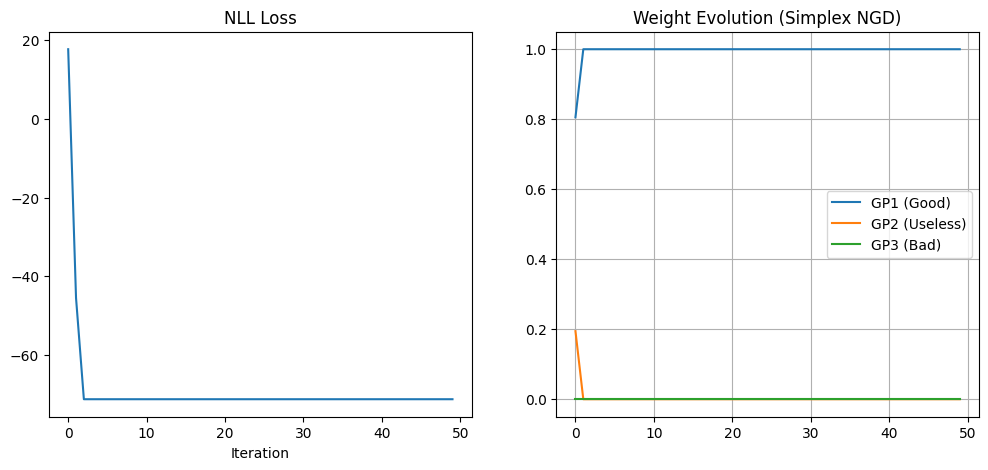

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# --- 0. Configuration ---
DTYPE = torch.float64
torch.set_default_dtype(DTYPE)

# --- 1. Optimizer (前回のまま) ---
class NaturalGradientSimplex(optim.Optimizer):
    def __init__(self, params, lr=0.1, damping=1e-5):
        defaults = dict(lr=lr, damping=damping)
        super(NaturalGradientSimplex, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue
                w = torch.softmax(p, dim=0)
                G = torch.diag(w) - torch.outer(w, w)
                G.diagonal().add_(group['damping'])
                grad_theta = p.grad
                nat_grad = torch.linalg.pinv(G) @ grad_theta
                p.sub_(group['lr'] * nat_grad)
        return loss

# --- 2. Weighted WBGP Model ---
class WeightedWBGP(nn.Module):
    def __init__(self, n_models):
        super(WeightedWBGP, self).__init__()
        # 自然パラメータ theta (logits) -> NGDで最適化
        self.theta = nn.Parameter(torch.zeros(n_models, dtype=DTYPE))

    @property
    def weights(self):
        return torch.softmax(self.theta, dim=0)

    def negative_log_likelihood(self, means, stds, y_target):
        """
        means: shape (N_models, N_data) - 各GPの予測平均
        stds:  shape (N_models, N_data) - 各GPの予測標準偏差
        y_target: shape (N_data)
        """
        w = self.weights
        
        # WBGPの定義に基づく合成 (Wasserstein Barycenter for 1D Gaussians)
        # mean_bar = sum w_i * mu_i
        # std_bar = sum w_i * sigma_i  (ここがMKLと違う！分散の和ではなく、標準偏差の和)
        
        # w: (N_models), means: (N_models, N_data) -> 放送して和をとる
        mu_bar = torch.sum(w.view(-1, 1) * means, dim=0)
        sigma_bar = torch.sum(w.view(-1, 1) * stds, dim=0)
        
        # ノイズ分散 (観測ノイズ) を少し足して安定化
        var_bar = sigma_bar**2 + 1e-6
        
        # Negative Log Likelihood (Gaussian)
        nll = 0.5 * torch.sum(torch.log(var_bar) + (y_target - mu_bar)**2 / var_bar)
        return nll

# --- 3. Experiment ---
torch.manual_seed(42)
np.random.seed(42)

# データ生成
N_DATA = 50
X = np.linspace(0, 10, N_DATA)
y_true = np.sin(X)
y_obs = torch.tensor(y_true + np.random.normal(0, 0.1, N_DATA), dtype=DTYPE)

# 複数の「専門家GP」をシミュレート
# GP1: 正解に近い
mu1 = y_true + np.random.normal(0, 0.1, N_DATA)
std1 = np.ones(N_DATA) * 0.2

# GP2: 常に0を予測する (役に立たない)
mu2 = np.zeros(N_DATA)
std2 = np.ones(N_DATA) * 1.0

# GP3: 逆位相を予測する (有害)
mu3 = -y_true
std3 = np.ones(N_DATA) * 0.2

# Tensor化
means = torch.tensor(np.array([mu1, mu2, mu3]), dtype=DTYPE)
stds = torch.tensor(np.array([std1, std2, std3]), dtype=DTYPE)

# モデル定義
model = WeightedWBGP(n_models=3)
optimizer = NaturalGradientSimplex([model.theta], lr=0.5)

print("Initial Weights:", np.round(model.weights.detach().numpy(), 3))

# 最適化ループ
losses = []
w_history = []

for i in range(50):
    optimizer.zero_grad()
    loss = model.negative_log_likelihood(means, stds, y_obs)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    w_history.append(model.weights.clone().detach().numpy())

# 結果表示
final_weights = model.weights.detach().numpy()
print("Final Weights:  ", np.round(final_weights, 3))
print("  (GP1=Good, GP2=Useless, GP3=Bad)")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("NLL Loss")
plt.xlabel("Iteration")

plt.subplot(1, 2, 2)
w_history = np.array(w_history)
plt.plot(w_history[:, 0], label="GP1 (Good)")
plt.plot(w_history[:, 1], label="GP2 (Useless)")
plt.plot(w_history[:, 2], label="GP3 (Bad)")
plt.title("Weight Evolution (Simplex NGD)")
plt.legend()
plt.grid()
plt.show()

Initializing WBGP with 32 base models...
Optimizing Barycentric Weights...


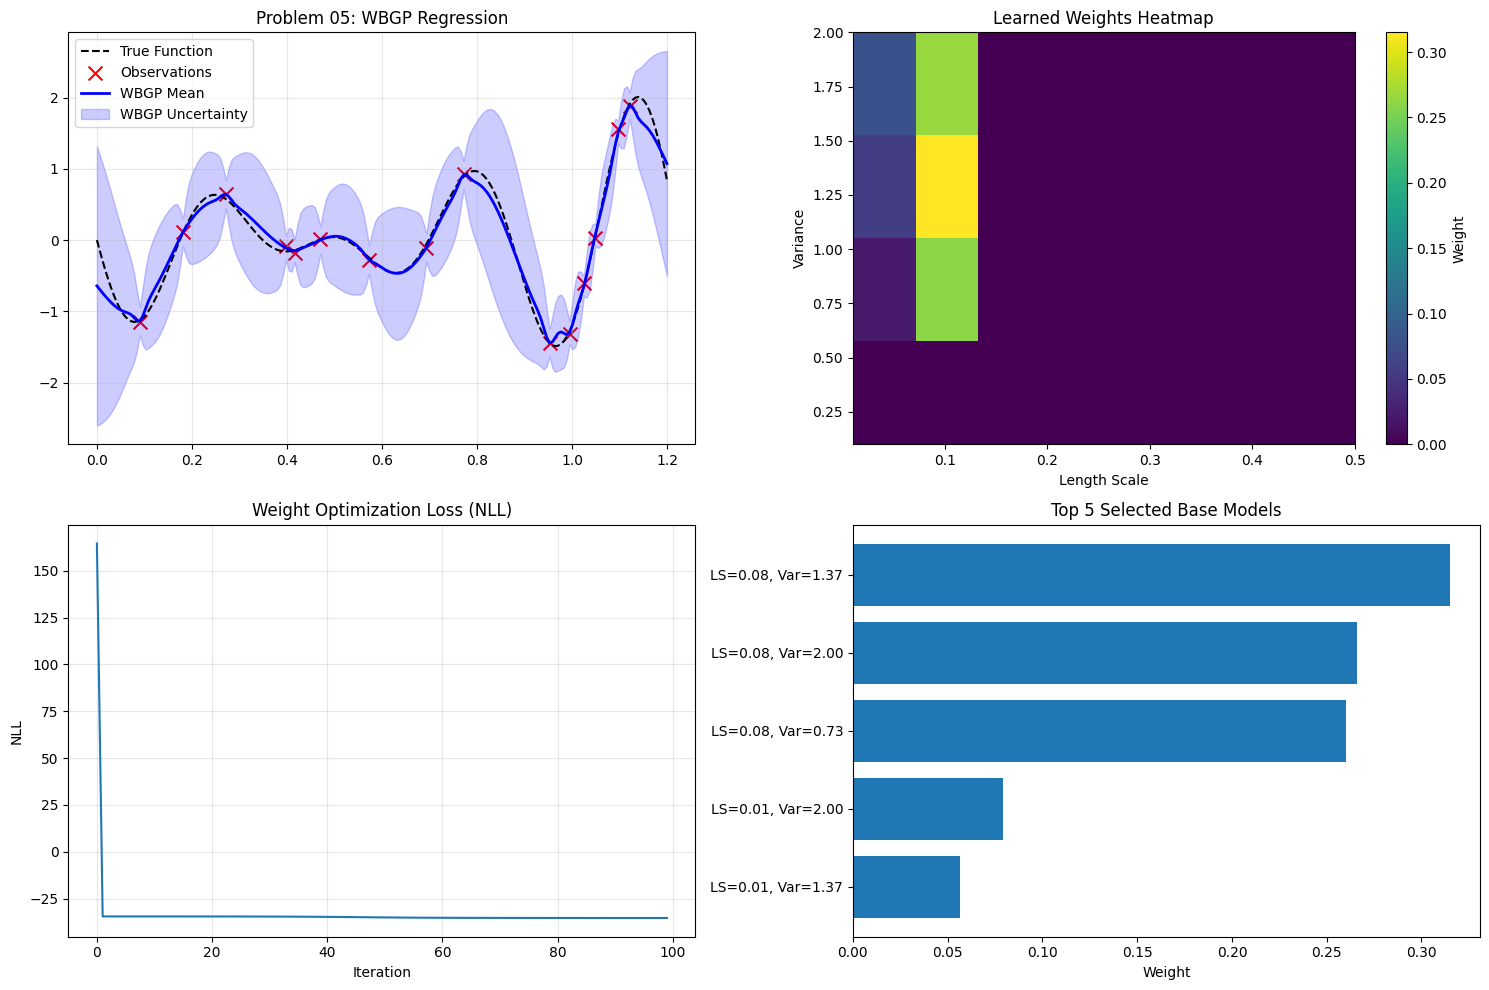

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# --- 0. Configuration ---
# 数値安定性のため倍精度 (Double) を使用
DTYPE = torch.float64
torch.set_default_dtype(DTYPE)

# --- 1. Optimizer (Simplex NGD) ---
class NaturalGradientSimplex(optim.Optimizer):
    """
    Legendre Decomposition に基づく確率単体上の自然勾配法。
    """
    def __init__(self, params, lr=0.1, damping=1e-5):
        defaults = dict(lr=lr, damping=damping)
        super(NaturalGradientSimplex, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue
                
                # p は自然パラメータ theta (logits)
                w = torch.softmax(p, dim=0)
                
                # フィッシャー情報行列 G = diag(w) - w @ w.T
                G = torch.diag(w) - torch.outer(w, w)
                G.diagonal().add_(group['damping'])
                
                grad_theta = p.grad
                
                # 自然勾配: inv(G) @ grad_theta
                # ランク落ちに対応するため pinv を使用
                nat_grad = torch.linalg.pinv(G) @ grad_theta
                
                # 更新
                p.sub_(group['lr'] * nat_grad)
        return loss

# --- 2. Base GP Class (Fixed Hyperparameters) ---
class FixedGP(nn.Module):
    """
    ハイパーパラメータ固定のガウス過程。
    解析解 (Cholesky分解) でフィッティングを行うため高速。
    """
    def __init__(self, length_scale, variance, noise_std=1e-4):
        super(FixedGP, self).__init__()
        self.ls = torch.tensor(length_scale, dtype=DTYPE)
        self.var = torch.tensor(variance, dtype=DTYPE)
        self.noise_std = torch.tensor(noise_std, dtype=DTYPE)
        self.X_train = None
        self.y_train = None
        self.L = None
        self.alpha = None

    def compute_kernel(self, X1, X2=None):
        if X2 is None: X2 = X1
        dists_sq = torch.cdist(X1, X2, p=2)**2
        K = self.var * torch.exp(-0.5 * dists_sq / (self.ls**2))
        return K

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        K = self.compute_kernel(X)
        K_noise = K + (self.noise_std**2) * torch.eye(len(X))
        
        try:
            self.L = torch.linalg.cholesky(K_noise)
            self.alpha = torch.cholesky_solve(y.unsqueeze(1), self.L)
        except RuntimeError:
            # エラー時はジッターを追加してリトライ
            K_noise += 1e-5 * torch.eye(len(X))
            self.L = torch.linalg.cholesky(K_noise)
            self.alpha = torch.cholesky_solve(y.unsqueeze(1), self.L)

    def predict(self, X_test):
        # 事後分布の平均と分散(対角成分)を計算
        K_trans = self.compute_kernel(X_test, self.X_train)
        mu = K_trans @ self.alpha
        
        v = torch.linalg.solve(self.L, K_trans.T)
        var_diag = self.var - torch.sum(v**2, dim=0)
        var_diag = torch.clamp(var_diag, min=1e-9) # 負値防止
        std = torch.sqrt(var_diag)
        return mu.squeeze(), std

# --- 3. WBGP with Weight Optimization ---
class OptimizedWBGP(nn.Module):
    def __init__(self, length_scales, variances, noise_std=1e-4):
        super(OptimizedWBGP, self).__init__()
        
        # GPバンクの作成
        self.models = []
        self.param_grid = []
        for ls in length_scales:
            for v in variances:
                gp = FixedGP(ls, v, noise_std)
                self.models.append(gp)
                self.param_grid.append((ls, v))
        
        self.n_models = len(self.models)
        
        # 重みパラメータ (Simplex NGD用)
        self.theta = nn.Parameter(torch.zeros(self.n_models, dtype=DTYPE))

    @property
    def weights(self):
        return torch.softmax(self.theta, dim=0)

    def fit_base_models(self, X, y):
        # 全てのベースモデルをデータに適合させる
        for gp in self.models:
            gp.fit(X, y)

    def optimize_weights(self, X_train, y_train, n_iter=100, lr=0.5):
        """
        NGDを用いて重みを最適化する。
        各GPの予測値を事前計算(Cache)することで高速化。
        """
        # Step 1: Precompute predictions
        mus = []
        stds = []
        with torch.no_grad():
            for gp in self.models:
                m, s = gp.predict(X_train)
                mus.append(m)
                stds.append(s)
        
        # (N_models, N_data)
        mus_tensor = torch.stack(mus)
        stds_tensor = torch.stack(stds)
        
        # Step 2: Optimization Loop
        optimizer = NaturalGradientSimplex([self.theta], lr=lr)
        loss_history = []

        for i in range(n_iter):
            optimizer.zero_grad()
            w = self.weights
            
            # WBGP Aggregation (Barycenter)
            mu_bar = torch.sum(w.view(-1, 1) * mus_tensor, dim=0)
            sigma_bar = torch.sum(w.view(-1, 1) * stds_tensor, dim=0)
            
            # Negative Log Likelihood
            var_bar = sigma_bar**2 + 1e-6
            nll = 0.5 * torch.sum(torch.log(var_bar) + (y_train - mu_bar)**2 / var_bar)
            
            nll.backward()
            optimizer.step()
            loss_history.append(nll.item())
            
        return loss_history

    def predict(self, X_test):
        # 重み付きバリセンター予測
        mus = []
        stds = []
        with torch.no_grad():
            for gp in self.models:
                m, s = gp.predict(X_test)
                mus.append(m)
                stds.append(s)
        
        mus_tensor = torch.stack(mus)
        stds_tensor = torch.stack(stds)
        w = self.weights
        
        mu_bar = torch.sum(w.view(-1, 1) * mus_tensor, dim=0)
        sigma_bar = torch.sum(w.view(-1, 1) * stds_tensor, dim=0)
        
        return mu_bar, sigma_bar

# --- 4. Experiment: Problem 05 ---
def problem_05(x):
    return -(1.4 - 3*x) * np.sin(18*x)

torch.manual_seed(42)
np.random.seed(42)

# データ生成
X_np = np.linspace(0, 1.2, 200)
y_true = problem_05(X_np)

# 訓練データ (ランダムに15点)
train_idx = np.random.choice(len(X_np), 15, replace=False)
X_train_np = X_np[train_idx].reshape(-1, 1)
y_train_np = y_true[train_idx] + np.random.normal(0, 0.05, 15)

X_test = torch.tensor(X_np.reshape(-1, 1), dtype=DTYPE)
X_train = torch.tensor(X_train_np, dtype=DTYPE)
y_train = torch.tensor(y_train_np, dtype=DTYPE)

# --- WBGP Setup ---
# ハイパーパラメータのグリッド
ls_grid = np.linspace(0.01, 0.5, 8)
var_grid = np.linspace(0.1, 2.0, 4)

print(f"Initializing WBGP with {len(ls_grid) * len(var_grid)} base models...")
model = OptimizedWBGP(ls_grid, var_grid, noise_std=0.1)

# 1. Fit Base Models
model.fit_base_models(X_train, y_train)

# 2. Optimize Weights
print("Optimizing Barycentric Weights...")
loss_hist = model.optimize_weights(X_train, y_train, n_iter=100, lr=0.1)

# 3. Prediction
mu_pred, std_pred = model.predict(X_test)

# --- 修正箇所: Tensor から NumPy への変換 ---
# 計算グラフを切るために .detach() を挟みます
mu_pred = mu_pred.detach().numpy()
std_pred = std_pred.detach().numpy()

# --- Visualization ---
plt.figure(figsize=(15, 10))

# Result Plot
plt.subplot(2, 2, 1)
plt.plot(X_np, y_true, 'k--', label='True Function')
plt.scatter(X_train_np, y_train_np, c='r', marker='x', s=100, label='Observations')
plt.plot(X_np, mu_pred, 'b-', linewidth=2, label='WBGP Mean')
plt.fill_between(X_np, mu_pred - 2*std_pred, mu_pred + 2*std_pred, color='b', alpha=0.2, label='WBGP Uncertainty')
plt.title('Problem 05: WBGP Regression')
plt.legend()
plt.grid(True, alpha=0.3)

# Weight Heatmap
plt.subplot(2, 2, 2)
weights = model.weights.detach().numpy()
w_grid = weights.reshape(len(ls_grid), len(var_grid))
plt.imshow(w_grid.T, origin='lower', aspect='auto', cmap='viridis', extent=[ls_grid[0], ls_grid[-1], var_grid[0], var_grid[-1]])
plt.colorbar(label='Weight')
plt.xlabel('Length Scale')
plt.ylabel('Variance')
plt.title('Learned Weights Heatmap')

# Loss Curve
plt.subplot(2, 2, 3)
plt.plot(loss_hist)
plt.title('Weight Optimization Loss (NLL)')
plt.xlabel('Iteration')
plt.ylabel('NLL')
plt.grid(True, alpha=0.3)

# Selected Models Analysis
plt.subplot(2, 2, 4)
top_k_idx = np.argsort(weights)[-5:] # Top 5 models
plt.barh(range(5), weights[top_k_idx])
labels = [f"LS={model.param_grid[i][0]:.2f}, Var={model.param_grid[i][1]:.2f}" for i in top_k_idx]
plt.yticks(range(5), labels)
plt.title('Top 5 Selected Base Models')
plt.xlabel('Weight')

plt.tight_layout()
plt.show()